# 1. Environment setup
Install and import necessary packages to the current code environment.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

Define any necessary utility or helper functions (e.g., for plotting, optimization, etc.) if applicable.

In [2]:
# TODO: Define helper function (e.g. plotting) if applicable
# Define the function to draw the image of the original data.
def draw_image(ax, index, images, labels):
    image = images[index]
    label = labels[index]
    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
# Define the function to flip and rotate the image.
def rotation(image):
    image = image.reshape(-1, 28, 28)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image
# Reference:
    # This function was adapted from the code given by the Kaggle Code:
    # ABDUTTAYYEB RAMPURAWALA. "Alphabet/Letter Recognition EMNIST-balanced."
    # Kaggle,
    # "https://www.kaggle.com/code/abtabm/" \
    # "alphabet-letter-recognition-emnist-balanced"
    # Accessed on 2024-10-02.
# Define the residual_block function.
def residual_block(x, filters, kernel_size = 3, stride = 1,
                                         downsample = None):
    symbol = x
    # The first convolutional layer
    x = layers.Conv2D(filters, kernel_size = kernel_size,
                                 strides = stride, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # The second convolutional layer
    x = layers.Conv2D(filters, kernel_size = kernel_size,
                                      strides = 1, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    # Deal with the downsample
    if downsample:
        for layer in downsample:
            symbol = layer(symbol)
    # skip connection
    x = layers.Add()([symbol, x])
    x = layers.Activation('relu')(x)
    return x
# Define the stack function to stack residual blocks
def stack(x, filters, stride):
    downsample = None
    # Acquire the numbers of channels of input tensor
    input_filters = x.shape[3]
    # Create downsample layers if necessary
    if input_filters != filters or stride != 1:
        downsample = [
            layers.Conv2D(filters = filters, kernel_size = 1,
                                strides = stride, padding = 'same'),
            layers.BatchNormalization()
        ]
    x = residual_block(x, filters, stride = stride, downsample = downsample)
    return x
# Reference:
    # This function was adapted from the code given by the Github Code:
    # Jimmy Wu. "resnet18-tf2."
    # Github,
    # "https://github.com/jimmyyhwu/resnet18-tf2"
    # Accessed on 2024-10-03.
# Define the MBConv_Block
def mbconv_block(inputs, filters, kernel_size, strides, expand_ratio,
                                                        survival_prob = 0.8):
    input_channels = inputs.shape[-1]
    # Expansion phase
    x = layers.Conv2D(input_channels * expand_ratio, kernel_size = 1,
                                 padding='same', use_bias = False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size, strides = strides,
                                     padding='same', use_bias = False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    # Squeeze and Excitation phase
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(input_channels * expand_ratio // 4,
                                                     activation = 'swish')(se)
    se = layers.Dense(input_channels * expand_ratio,
                                                   activation = 'sigmoid')(se)
    se = layers.Reshape([1, 1, input_channels * expand_ratio])(se)
    x =  layers.multiply([x, se])
    #  Output phase
    x =  layers.Conv2D(filters, kernel_size = 1, padding = 'same',
                                                        use_bias=False)(x)
    x =  layers.BatchNormalization()(x)
    # Dropout layer
    if strides == 1 and input_channels == filters:
        if survival_prob:
            x = layers.Dropout(1 - survival_prob)(x)
        x = layers.add([x, inputs])
    return x
# Reference:
    # This function was adapted from the code given by the Github Code:
    # Pavel Iakubovskii et al."efficientnet"
    # Github,
    # "https://github.com/qubvel/efficientnet"
    # Accessed on 2024-10-04.
# draw the classification report
def draw_table_classification_report(report):
    df = pd.DataFrame(report).transpose()
    plt.figure(figsize = (20,15))
    sns.heatmap(df.iloc[:-1,:-1],annot = True, cmap = 'Blues',fmt = ".2f")
    plt.title("Classification Report")
    plt.show()
# draw the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (30, 30))
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
# draw the radar chart
def plot_radar_chart(labels, scores, classifiers, title):
# This function creates a radar chart to compare performance scores
# of different classifiers across various evaluation metrics.
# determine the number of variables we have, based on labels
    num_vars = len(labels)
    # compute the angles for each axis in the rader chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint = False).tolist()
    # ensures the rader chart forms a closed shape
    scores = [score + score[:1] for score in scores]
    angles += angles[:1]
    # create the figure and a polar subplot
    figure, ax = plt.subplots(figsize = (10, 8),
    subplot_kw = dict(polar = True))
    # loop through each classifier and plot their scores
    for i, score in enumerate(scores):
      ax.plot(angles, score, linewidth = 1, linestyle ='solid',
                                                    label = classifiers[i])
      ax.fill(angles, score, alpha = 0.25)
    # set the labels for each axis in the rader chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    # set the y-axis ticks to specific score intervals (from 0.80 to 1.0)
    ax.set_yticks([0.80, 0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98, 1.0])
    ax.set_ylim(0.80, 1.0)
    # add a legend in the upper right, slightly outside the chart for clarity
    ax.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.21))
    plt.title(title)
    plt.show()
 # Reference:
 # This function was adapted from the tutorial given by
 # the Curbal Learning Portal:
 # Ruth Pozuelo Martinez. "Radar charts in matplotlib."
 # Curbal Learning Portal,
 # https://curbal.com/curbal-learning-portal/radar-charts-in-matplotlib
 # Accessed on 2024-09-04.

# 2. Data loading, pre-processing, and exploration

## 2.1 Data loading
Load the data that will be used in this task.

In [3]:
# TODO: Load the data
print(os.listdir("./EMNIST_Byclass_Small"))
data_train_df = pd.read_pickle('./EMNIST_Byclass_Small/emnist_train.pkl')
data_test_df = pd.read_pickle('./EMNIST_Byclass_Small/emnist_test.pkl')
print(data_train_df.keys())
# calculate the numbers of classes.
unique_classes = np.unique(data_train_df['labels'])
num_classes = len(unique_classes)
print(f"Number of classes: {num_classes}")

['dataset_description.txt.txt', 'emnist_test.pkl', 'emnist_train.pkl']
dict_keys(['data', 'labels'])
Number of classes: 62


## 2.2 Data exploration
Explore the data to better understand its properties.

### 2.2.1 Check if there is missing value
Observe the shape of train and test dataset, then check if they have
missing value.

In [4]:
# TODO: Acquire X_train, y_train, X_test, y_test, X_validation, y_validation
# and make sure if the data has missing value.
X_train = data_train_df['data']
y_train = data_train_df['labels']
print(f"x_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
X_test = data_test_df['data']
y_test = data_test_df['labels']
print(f"x_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
# acquire the validation dataset from the train dataset
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train,test_size = 0.1, random_state = 42)
print(np.isnan(X_train).any())
print(np.isnan(y_train).any())
print(np.isnan(X_test).any())
print(np.isnan(y_test).any())
print(np.isnan(X_validation).any())
print(np.isnan(y_validation).any())

x_train shape: (100000, 28, 28)
y_train shape: (100000,)
x_test shape: (20000, 28, 28)
y_test shape: (20000,)
False
False
False
False
False
False


### 2.2.2 Display ten random images of the original data
Select 10 images of the dataset randomly to further understand of the dataset.

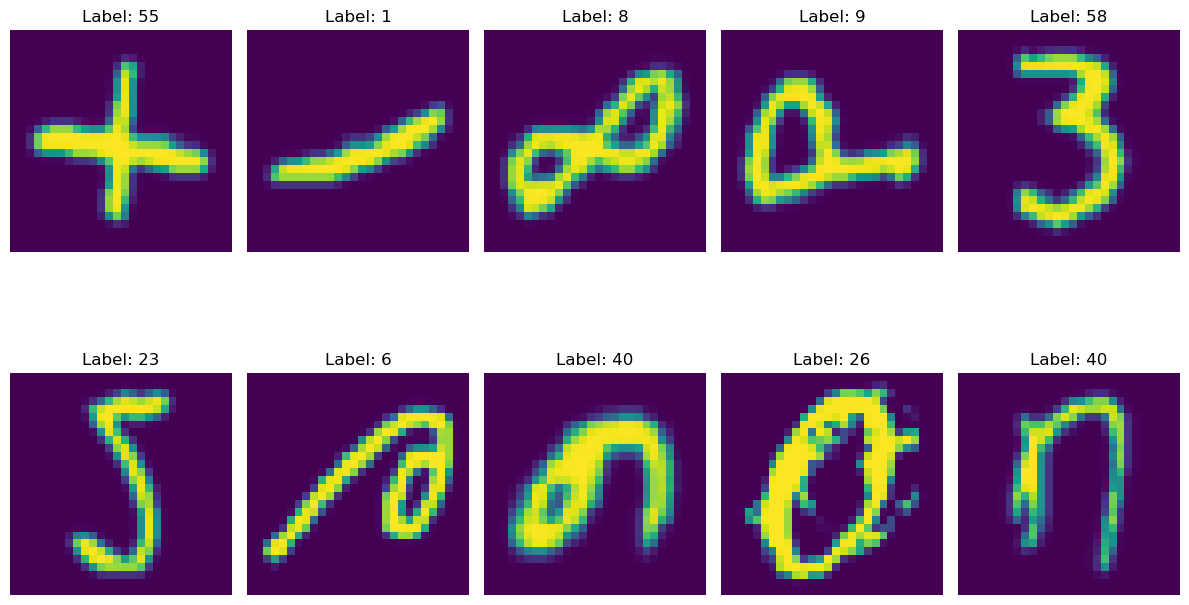

In [5]:
images = data_train_df['data']
labels = data_train_df['labels']
figure, ax = plt.subplots(2, 5, figsize=(12, 8))
for i in range(2):
    for j in range(5):
    # generate the random index
        random_index = np.random.randint(0, len(images) - 1)
        draw_image(ax[i, j], random_index, images, labels)
plt.tight_layout()
plt.show()

### 2.2.3 Pairplot Graph
Draw the Pairplot Graph to observe the pairwise relationship and distribution of features

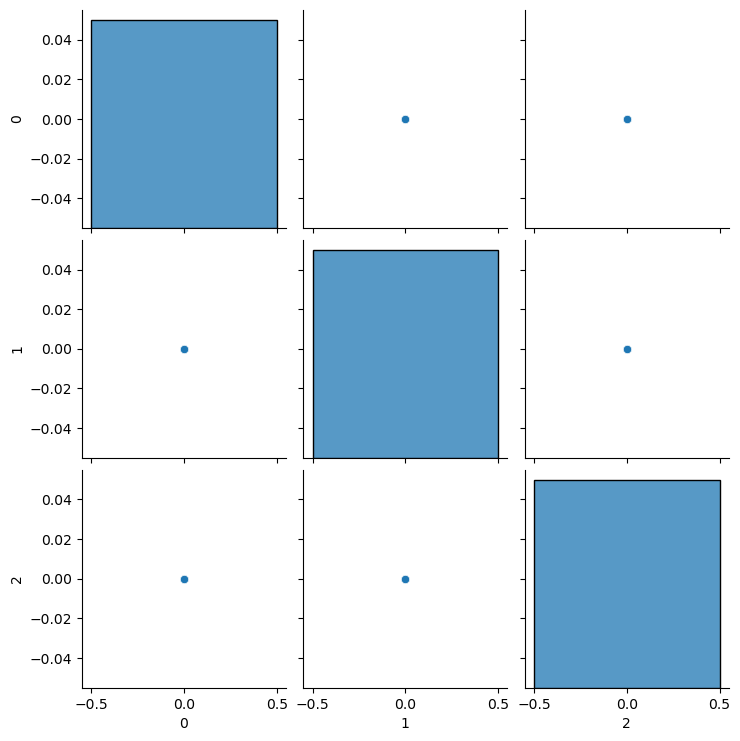

In [6]:
# Reshape data to 2D
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_validation = X_validation.reshape(X_validation.shape[0], -1)
# Transfer the data into dataframe
df = pd.DataFrame(X_train)
# Choose the first 3 features to visualize
sns.pairplot(df.iloc[:, :3])
plt.show()

### 2.2.4 Scatter Plot
Draw the Scatter Plot to observe the relationship between features.

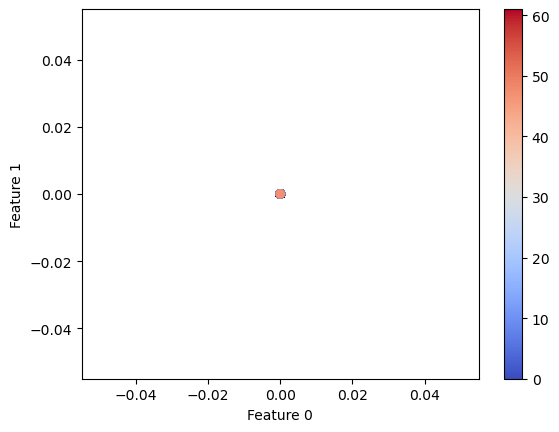

In [7]:
# Visualize the scatter plot between features
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = 'coolwarm')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.colorbar()
plt.show()

## 2.3 Data pre-processing
Implement specific preprocessing technique on the dataset before model training.
### 2.3.1 Data augmentation
Use image flip and rotate to make the images have a proper oritentation as much as possible.

(90000, 28, 1, 28)

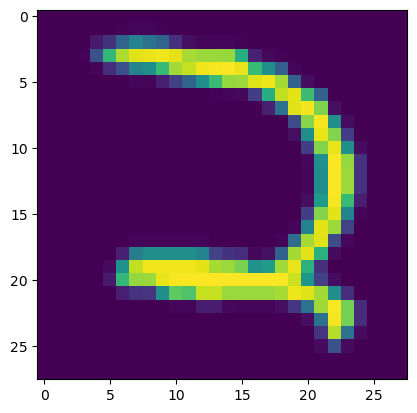

In [8]:
# Reshape data to 2D
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_validation = X_validation.reshape(X_validation.shape[0], -1)
X_train = np.apply_along_axis(rotation, 1 , X_train)
X_test = np.apply_along_axis(rotation, 1 , X_test)
X_validation = np.apply_along_axis(rotation, 1 , X_validation)
plt.imshow(X_train[0].reshape(28, 28))
X_train.shape

### 2.3.2 Normalization
Using MinMaxScaler to normalize the data.

In [9]:
# Reshape data to 2D
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_validation = X_validation.reshape(X_validation.shape[0], -1)
# Create the scaler
scaler = MinMaxScaler(feature_range = (0, 1))
# Fit the scaler on the training data
scaler.fit(X_train)
# normalize the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

# 3. Model Implementation and Hyper-parameters Tuning
## 3.1 ResNet-like
### model implementation
According to the common ResNet architecture, customize an architecture called ResNet-like as the model1.

2024-10-07 05:07:56.809738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-07 05:07:56.822365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-07 05:07:56.825033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-07 05:07:56.828576: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2024-10-07 05:08:02.097366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2024-10-07 05:08:04.205746: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


352/352 [==============================] - 10s 15ms/step - loss: 3.7203 - accuracy: 0.0984 - val_loss: 3.7100 - val_accuracy: 0.0554
Epoch 2/20
352/352 [==============================] - 5s 13ms/step - loss: 3.2928 - accuracy: 0.1362 - val_loss: 3.3514 - val_accuracy: 0.1903
Epoch 3/20
352/352 [==============================] - 4s 12ms/step - loss: 3.2055 - accuracy: 0.1499 - val_loss: 2.8494 - val_accuracy: 0.2365
Epoch 4/20
352/352 [==============================] - 4s 13ms/step - loss: 3.1289 - accuracy: 0.1693 - val_loss: 2.7701 - val_accuracy: 0.2582
Epoch 5/20
352/352 [==============================] - 4s 13ms/step - loss: 3.0972 - accuracy: 0.1786 - val_loss: 2.6797 - val_accuracy: 0.2587
Epoch 6/20
352/352 [==============================] - 4s 12ms/step - loss: 3.0132 - accuracy: 0.1968 - val_loss: 7.0062 - val_accuracy: 0.2130
Epoch 7/20
352/352 [==============================] - 12s 34ms/step - loss: 2.9539 - accuracy: 0.2072 - val_loss: 2.6968 - val_accuracy: 0.3034
Epoch 8/

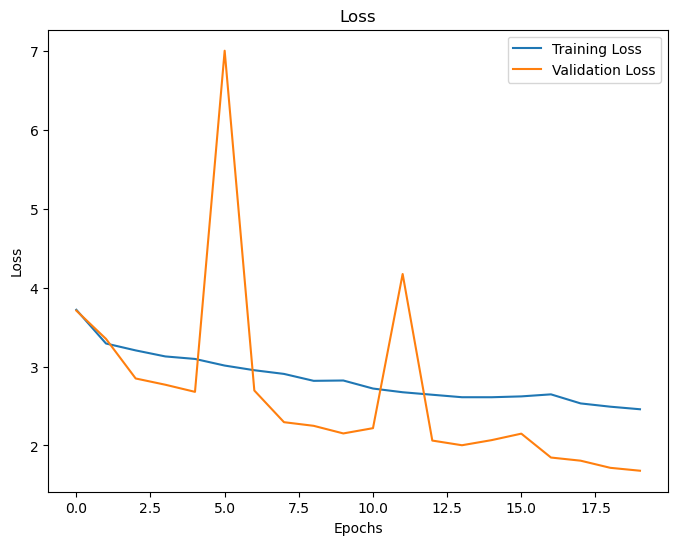

In [10]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# Transfer the shape of the dataset
X_train_scaled = X_train_scaled.reshape(-1, 28, 28, 1)
X_test_scaled =  X_test_scaled.reshape(-1, 28, 28, 1)
X_validation_scaled = X_validation_scaled.reshape(-1, 28, 28, 1)
# Create the ResNet-like architecture and encapsulate the model
def build_ResNet14(input_shape, num_classes = 62, dropout = 0.4,
                   learning_rate = 0.1):
    inputs = keras.Input(shape = input_shape)
    # define conv1 layer
    x = layers.ZeroPadding2D(padding = 3)(inputs)
    x = layers.Conv2D(64, kernel_size = 7, strides = 2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # define maxpool layer
    x = layers.ZeroPadding2D(padding = 1)(x)
    x = layers.MaxPool2D(pool_size = 3, strides = 2)(x)
    # stack the residual blocks
    x = stack(x, 64, stride = 1)
    x = layers.Dropout(dropout)(x)
    x = stack(x, 128, stride = 2)
    x = layers.Dropout(dropout)(x)
    x = stack(x, 256, stride = 2)
    x = layers.Dropout(dropout)(x)
    x = stack(x, 512, stride = 2)
    x = layers.Dropout(dropout)(x)
    # define the average pool layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation = 'softmax')(x)
    # compile the model
    model = Model(inputs = inputs, outputs = outputs)
    optimizer = optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = optimizer,
             loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
ResNet_model = build_ResNet14(input_shape = (28, 28, 1),
                              num_classes = num_classes)
# Train the model
history = ResNet_model.fit(X_train_scaled, y_train, epochs = 20,
    batch_size = 256, validation_data = (X_validation_scaled, y_validation))
# visualize the loss while training the model to observe the
# oscillation of the loss curve
plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
y_predict1 = ResNet_model.predict(X_test_scaled)
# Convert probabilities to class labels
y_predict1 = np.argmax(y_predict1, axis = 1)
accuracy1 = accuracy_score(y_predict1, y_test)
print(f'Test Accuracy: {accuracy1}')

Test Accuracy: 0.57185


### Grid search to implement hyper-parameters tuning
Enhance the model by fine-tuning its hyperparameters. Use grid search combined with k-fold cross-validation to systematically identify the optimal parameter set.

In [12]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
model1 = KerasClassifier(model = build_ResNet14, input_shape=(28, 28, 1),
          num_classes = num_classes, loss = "sparse_categorical_crossentropy",
            optimizer="adam", learning_rate = 0.1, metrics=["accuracy"],
            dropout = 0.4, epochs = 20)
# Define the parameters grid
param_grid = {
    'learning_rate': [0.001, 0.1, 0.01],
    'dropout': [0.2, 0.3, 0.4],
    'epochs': [10, 20],
}
# Use GridSearch to search the best parameters
grid = GridSearchCV(estimator = model1, param_grid = param_grid, cv = 3)
# Having Grid Search
grid_result = grid.fit(X_train_scaled, y_train, verbose = 0)
# Acquire the best result and the best parameter
print(f"Best Accuracy: {grid_result.best_score_} \
       with the best parameters: {grid_result.best_params_}")

938/938 [==============================] - 3s 3ms/step
Best Accuracy: 0.860588888888889        with the best parameters: {'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.001}


## 3.2 Simple CNN
Create a simple CNN architecture as the model2.
### model implementation
Implement a simple CNN architecture as the model2.

Epoch 1/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9737 - accuracy: 0.7101 - val_loss: 0.6931 - val_accuracy: 0.7772
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7240 - accuracy: 0.7665 - val_loss: 0.6534 - val_accuracy: 0.7893
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6806 - accuracy: 0.7778 - val_loss: 0.6485 - val_accuracy: 0.7937
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6446 - accuracy: 0.7859 - val_loss: 0.6269 - val_accuracy: 0.7978
Epoch 5/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6372 - accuracy: 0.7885 - val_loss: 0.6452 - val_accuracy: 0.7949
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6230 - accuracy: 0.7926 - val_loss: 0.6497 - val_accuracy: 0.8015
Epoch 7/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6214 - accuracy: 0.7918 - val_loss: 0.6488 - val_accuracy:

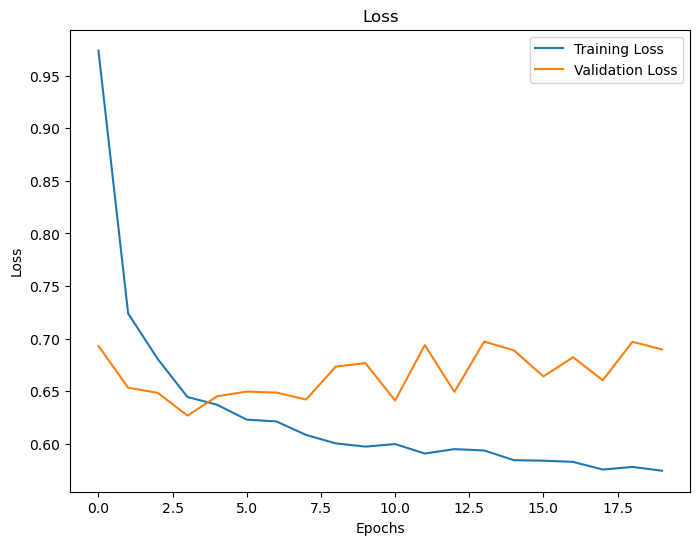

In [13]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# Transfer the shape of the dataset
X_train_scaled = X_train_scaled.reshape(-1, 28, 28, 1)
X_test_scaled =  X_test_scaled.reshape(-1, 28, 28, 1)
X_validation_scaled = X_validation_scaled.reshape(-1, 28, 28, 1)
# Create Simple CNN architecture and encapsulate the model
def build_CNN(learning_rate = 0.01, dropout = 0.1):
    model_2 = keras.Sequential([
    # The first convolutional layers
    layers.Conv2D(32, (3, 1), activation = 'relu', input_shape = (28, 28, 1)),
    layers.MaxPooling2D(pool_size = (2, 1)),
    layers.Dropout(dropout),
    # The second convolutional layers
    layers.Conv2D(64, (3, 1), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 1)),
    layers.Dropout(dropout),
    # Flatten the tensor
    layers.Flatten(),
    # Full connected layers
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(dropout),
    # Output layers
    layers.Dense(62, activation = 'softmax')])
    # Compile the model
    optimizer = optimizers.Adam(learning_rate = learning_rate)
    model_2.compile(optimizer = optimizer,
            loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model_2
# Train the model
CNN = build_CNN()
history2 = CNN.fit(X_train_scaled, y_train, epochs = 20, batch_size = 64,
                    validation_data = (X_validation_scaled, y_validation))
# visualize the training loss and validation loss while training the model to
# observe the oscillation of the loss curve
plt.figure(figsize = (8, 6))
plt.plot(history2.history['loss'], label = 'Training Loss')
plt.plot(history2.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
y_predict2 = CNN.predict(X_test_scaled)
# Convert probabilities to class labels
y_predict2 = np.argmax(y_predict2, axis = 1)
accuracy2 = accuracy_score(y_predict2, y_test)
print(f'Test Accuracy: {accuracy2}')

Test Accuracy: 0.8067


### Grid search to implement hyper-parameters tuning
Enhance the model by fine-tuning its hyperparameters. Use grid search combined with k-fold cross-validation to systematically identify the optimal parameter set.

In [15]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
model2 = KerasClassifier(model = build_CNN,  optimizer = "adam",
            loss = "sparse_categorical_crossentropy", learning_rate = 0.01,
            metrics=["accuracy"], dropout = 0.1, epochs = 20)
# Define the parameters grid
param_grid2 = {
    'learning_rate': [0.01,  0.001],
    'dropout': [0.1, 0.2, 0.3],
    'epochs': [20, 25],
}
# Use GridSearch to search the best parameters
grid2 = GridSearchCV(estimator = model2, param_grid = param_grid2, cv = 3)
# Having Grid Search
grid_result2 = grid2.fit(X_train_scaled, y_train, verbose = 0)
# Acquire the best result and the best parameter
print(f"Best Accuracy: {grid_result2.best_score_} \
       with the best parameters: {grid_result2.best_params_}")

938/938 [==============================] - 2s 2ms/step
Best Accuracy: 0.8208333333333334        with the best parameters: {'dropout': 0.3, 'epochs': 20, 'learning_rate': 0.001}


## 3.3 EfficientNet-like
Create a EfficientNet-like architecture as the model3.
### model implementation
Implement the EfficientNet-like architecture according to the common EfficientNet achitecture as the model3.

Epoch 1/20
352/352 [==============================] - 14s 27ms/step - loss: 1.6902 - accuracy: 0.5544 - val_loss: 4.0827 - val_accuracy: 0.0482
Epoch 2/20
352/352 [==============================] - 8s 24ms/step - loss: 0.6919 - accuracy: 0.7766 - val_loss: 1.7800 - val_accuracy: 0.7034
Epoch 3/20
352/352 [==============================] - 8s 23ms/step - loss: 0.5327 - accuracy: 0.8180 - val_loss: 0.5561 - val_accuracy: 0.8092
Epoch 4/20
352/352 [==============================] - 8s 22ms/step - loss: 0.4592 - accuracy: 0.8390 - val_loss: 0.5434 - val_accuracy: 0.8134
Epoch 5/20
352/352 [==============================] - 8s 23ms/step - loss: 0.4093 - accuracy: 0.8528 - val_loss: 0.5218 - val_accuracy: 0.8188
Epoch 6/20
352/352 [==============================] - 8s 24ms/step - loss: 0.3725 - accuracy: 0.8645 - val_loss: 0.5201 - val_accuracy: 0.8176
Epoch 7/20
352/352 [==============================] - 8s 23ms/step - loss: 0.3397 - accuracy: 0.8745 - val_loss: 0.5328 - val_accuracy: 0.820

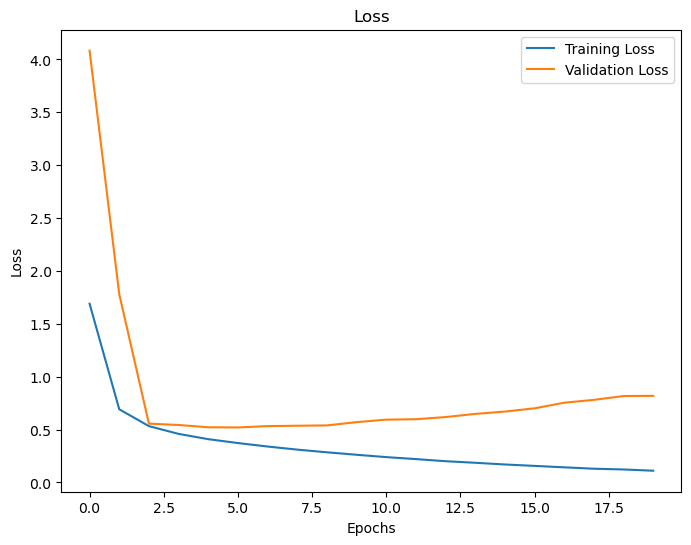

In [16]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# Transfer the shape of the dataset
X_train_scaled = X_train_scaled.reshape(-1, 28, 28, 1)
X_test_scaled =  X_test_scaled.reshape(-1, 28, 28, 1)
X_validation_scaled = X_validation_scaled.reshape(-1, 28, 28, 1)
# Create the EfficientNet-like architecture and encapsulate the model
def build_efficientnet_like(input_shape = (28, 28, 1), num_classes = 62,
                      learning_rate = 0.0001, survival_prob = 0.8):
    inputs = layers.Input(shape = input_shape)
    # Build the stem block
    x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 2,
                          padding = 'same', use_bias = False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    # Stack mbconv blocks
    x = mbconv_block(x, filters = 16, kernel_size = 3, strides = 1,
                expand_ratio = 1, survival_prob = survival_prob)
    x = mbconv_block(x, filters = 24, kernel_size = 3, strides = 2,
                expand_ratio = 6, survival_prob = survival_prob)
    x = mbconv_block(x, filters = 40, kernel_size = 5, strides = 2,
                expand_ratio = 6, survival_prob = survival_prob)
    x = mbconv_block(x, filters = 80, kernel_size = 3, strides = 2,
                expand_ratio = 6, survival_prob = survival_prob)
    x = mbconv_block(x, filters = 112, kernel_size = 5, strides = 1,
                expand_ratio = 6, survival_prob = survival_prob)
    x = mbconv_block(x, filters = 192, kernel_size = 5, strides = 2,
                expand_ratio = 6, survival_prob = survival_prob)
    x = mbconv_block(x, filters = 320, kernel_size = 3, strides = 1,
                expand_ratio = 6, survival_prob = survival_prob)
    # Build top
    x = layers.Conv2D(filters = 1280, kernel_size = 1, padding ='same',
                            use_bias = False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    # Bulid pooling and classification
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    # Compile the model
    model = Model(inputs = inputs, outputs = x)
    optimizer = optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
EfficientNet_model = build_efficientnet_like(input_shape = (28, 28, 1),
                                       num_classes = num_classes)
# Train the model
history = EfficientNet_model.fit(X_train_scaled, y_train, epochs = 20,
     batch_size = 256, validation_data = (X_validation_scaled, y_validation))
# visualize the loss while training the model to observe the
# oscillation of the loss curve
plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
y_predict3 = EfficientNet_model.predict(X_test_scaled)
# Convert probabilities to class labels
y_predict3 = np.argmax(y_predict3, axis = 1)
accuracy3 = accuracy_score(y_predict3, y_test)
print(f'Test Accuracy: {accuracy3}')

Test Accuracy: 0.80915


### Grid search to implement hyper-parameters tuning
Enhance the model by fine-tuning its hyperparameters. Use grid search combined with k-fold cross-validation to systematically identify the optimal parameter set.

In [18]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
model3 = KerasClassifier(model = build_efficientnet_like,  optimizer = "adam",
            loss = "sparse_categorical_crossentropy", learning_rate = 0.0001,
            metrics=["accuracy"], survival_prob = 0.8, epochs = 20)
# Define the parameters grid
param_grid3 = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'survival_prob': [0.8, 0.7, 0.6],
    'batch_size': [128, 256],
}
# Use GridSearch to search the best parameters
grid3 = GridSearchCV(estimator = model3, param_grid = param_grid3, cv = 3)
# Having Grid Search
grid_result3 = grid3.fit(X_train_scaled, y_train, verbose = 0)
# Acquire the best result and the best parameter
print(f"Best Accuracy: {grid_result3.best_score_} \
       with the best parameters: {grid_result3.best_params_}")

118/118 [==============================] - 1s 6ms/step
Best Accuracy: 0.8413444444444446        with the best parameters: {'batch_size': 128, 'learning_rate': 0.001, 'survival_prob': 0.8}


# 4.Evaluation and comparision
## 4.1 Evaluation on the validation dataset
Evaluate the model performance on the validation dataset.
### 4.1.1 ResNet-like evaluation on the validation dataset
Evaluate the ResNet-like architecture on the validation dataset.

Epoch 1/20
352/352 [==============================] - 7s 15ms/step - loss: 1.1635 - accuracy: 0.6751 - val_loss: 4.8945 - val_accuracy: 0.1262
Epoch 2/20
352/352 [==============================] - 5s 14ms/step - loss: 0.5759 - accuracy: 0.8036 - val_loss: 0.6164 - val_accuracy: 0.7865
Epoch 3/20
352/352 [==============================] - 5s 14ms/step - loss: 0.5029 - accuracy: 0.8248 - val_loss: 0.6249 - val_accuracy: 0.7987
Epoch 4/20
352/352 [==============================] - 5s 14ms/step - loss: 0.4653 - accuracy: 0.8348 - val_loss: 0.4732 - val_accuracy: 0.8326
Epoch 5/20
352/352 [==============================] - 5s 14ms/step - loss: 0.4411 - accuracy: 0.8427 - val_loss: 0.4137 - val_accuracy: 0.8506
Epoch 6/20
352/352 [==============================] - 5s 14ms/step - loss: 0.4287 - accuracy: 0.8448 - val_loss: 0.4591 - val_accuracy: 0.8372
Epoch 7/20
352/352 [==============================] - 5s 14ms/step - loss: 0.4142 - accuracy: 0.8485 - val_loss: 0.4298 - val_accuracy: 0.8471

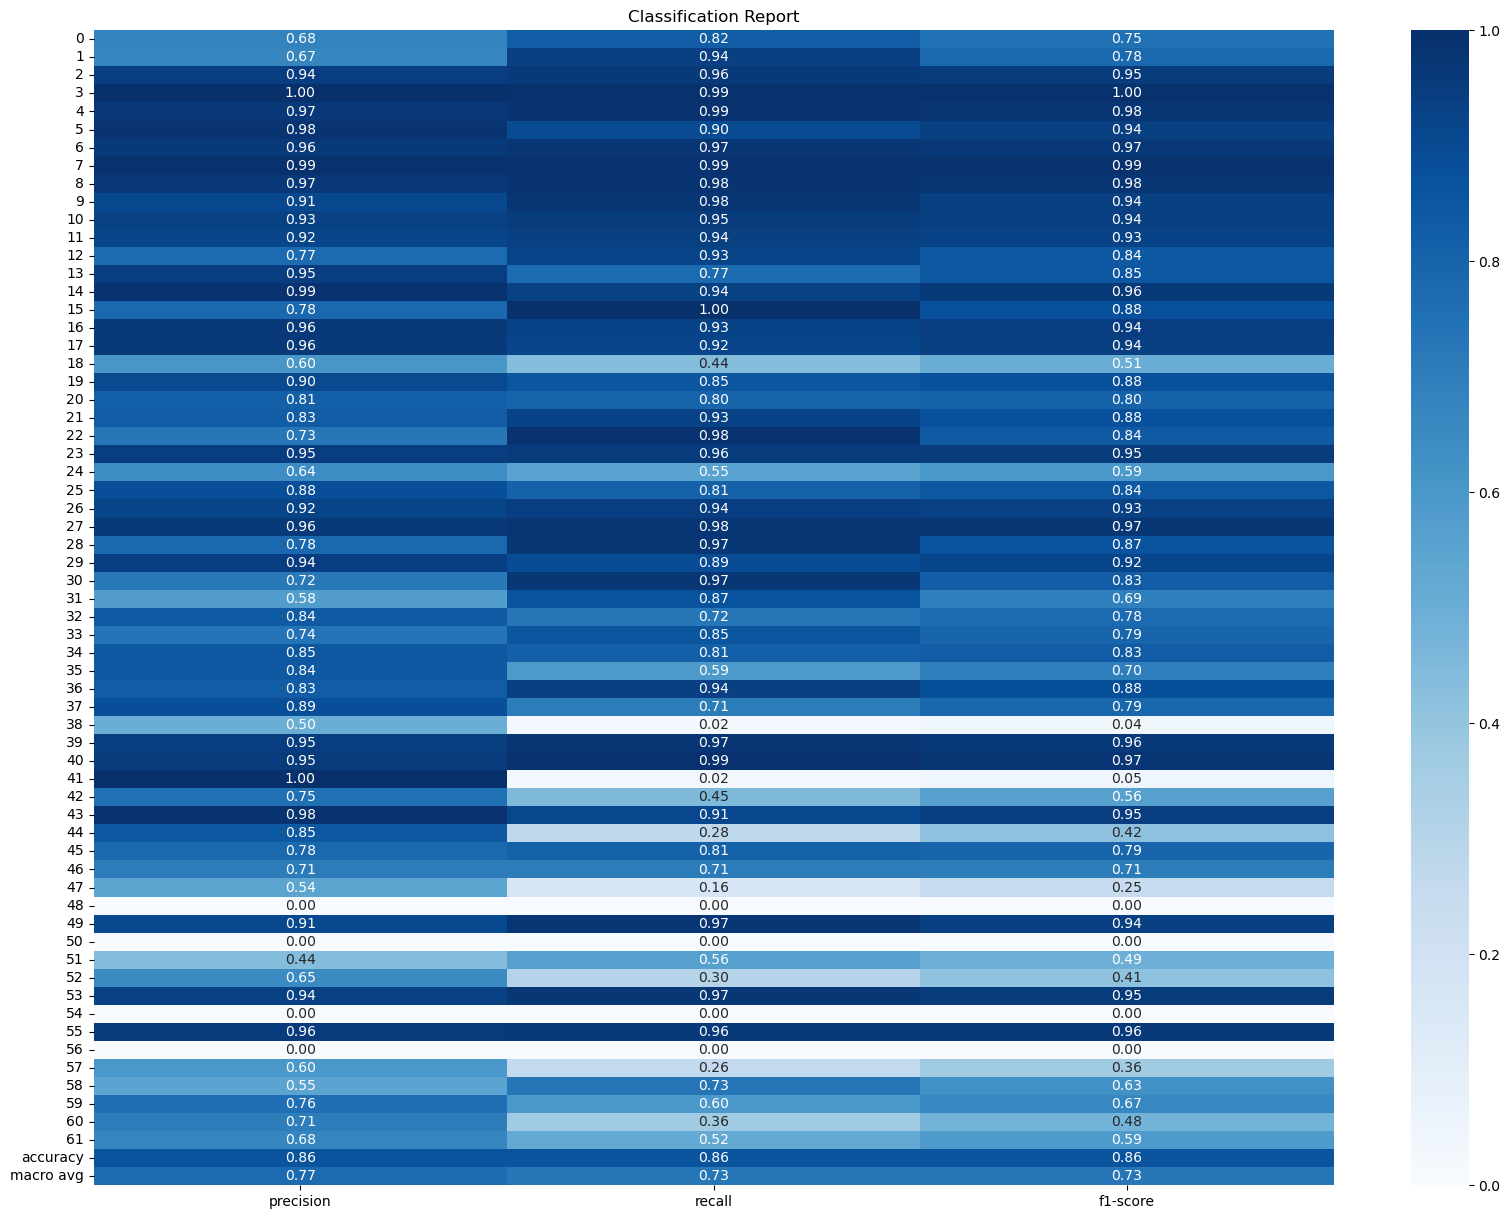

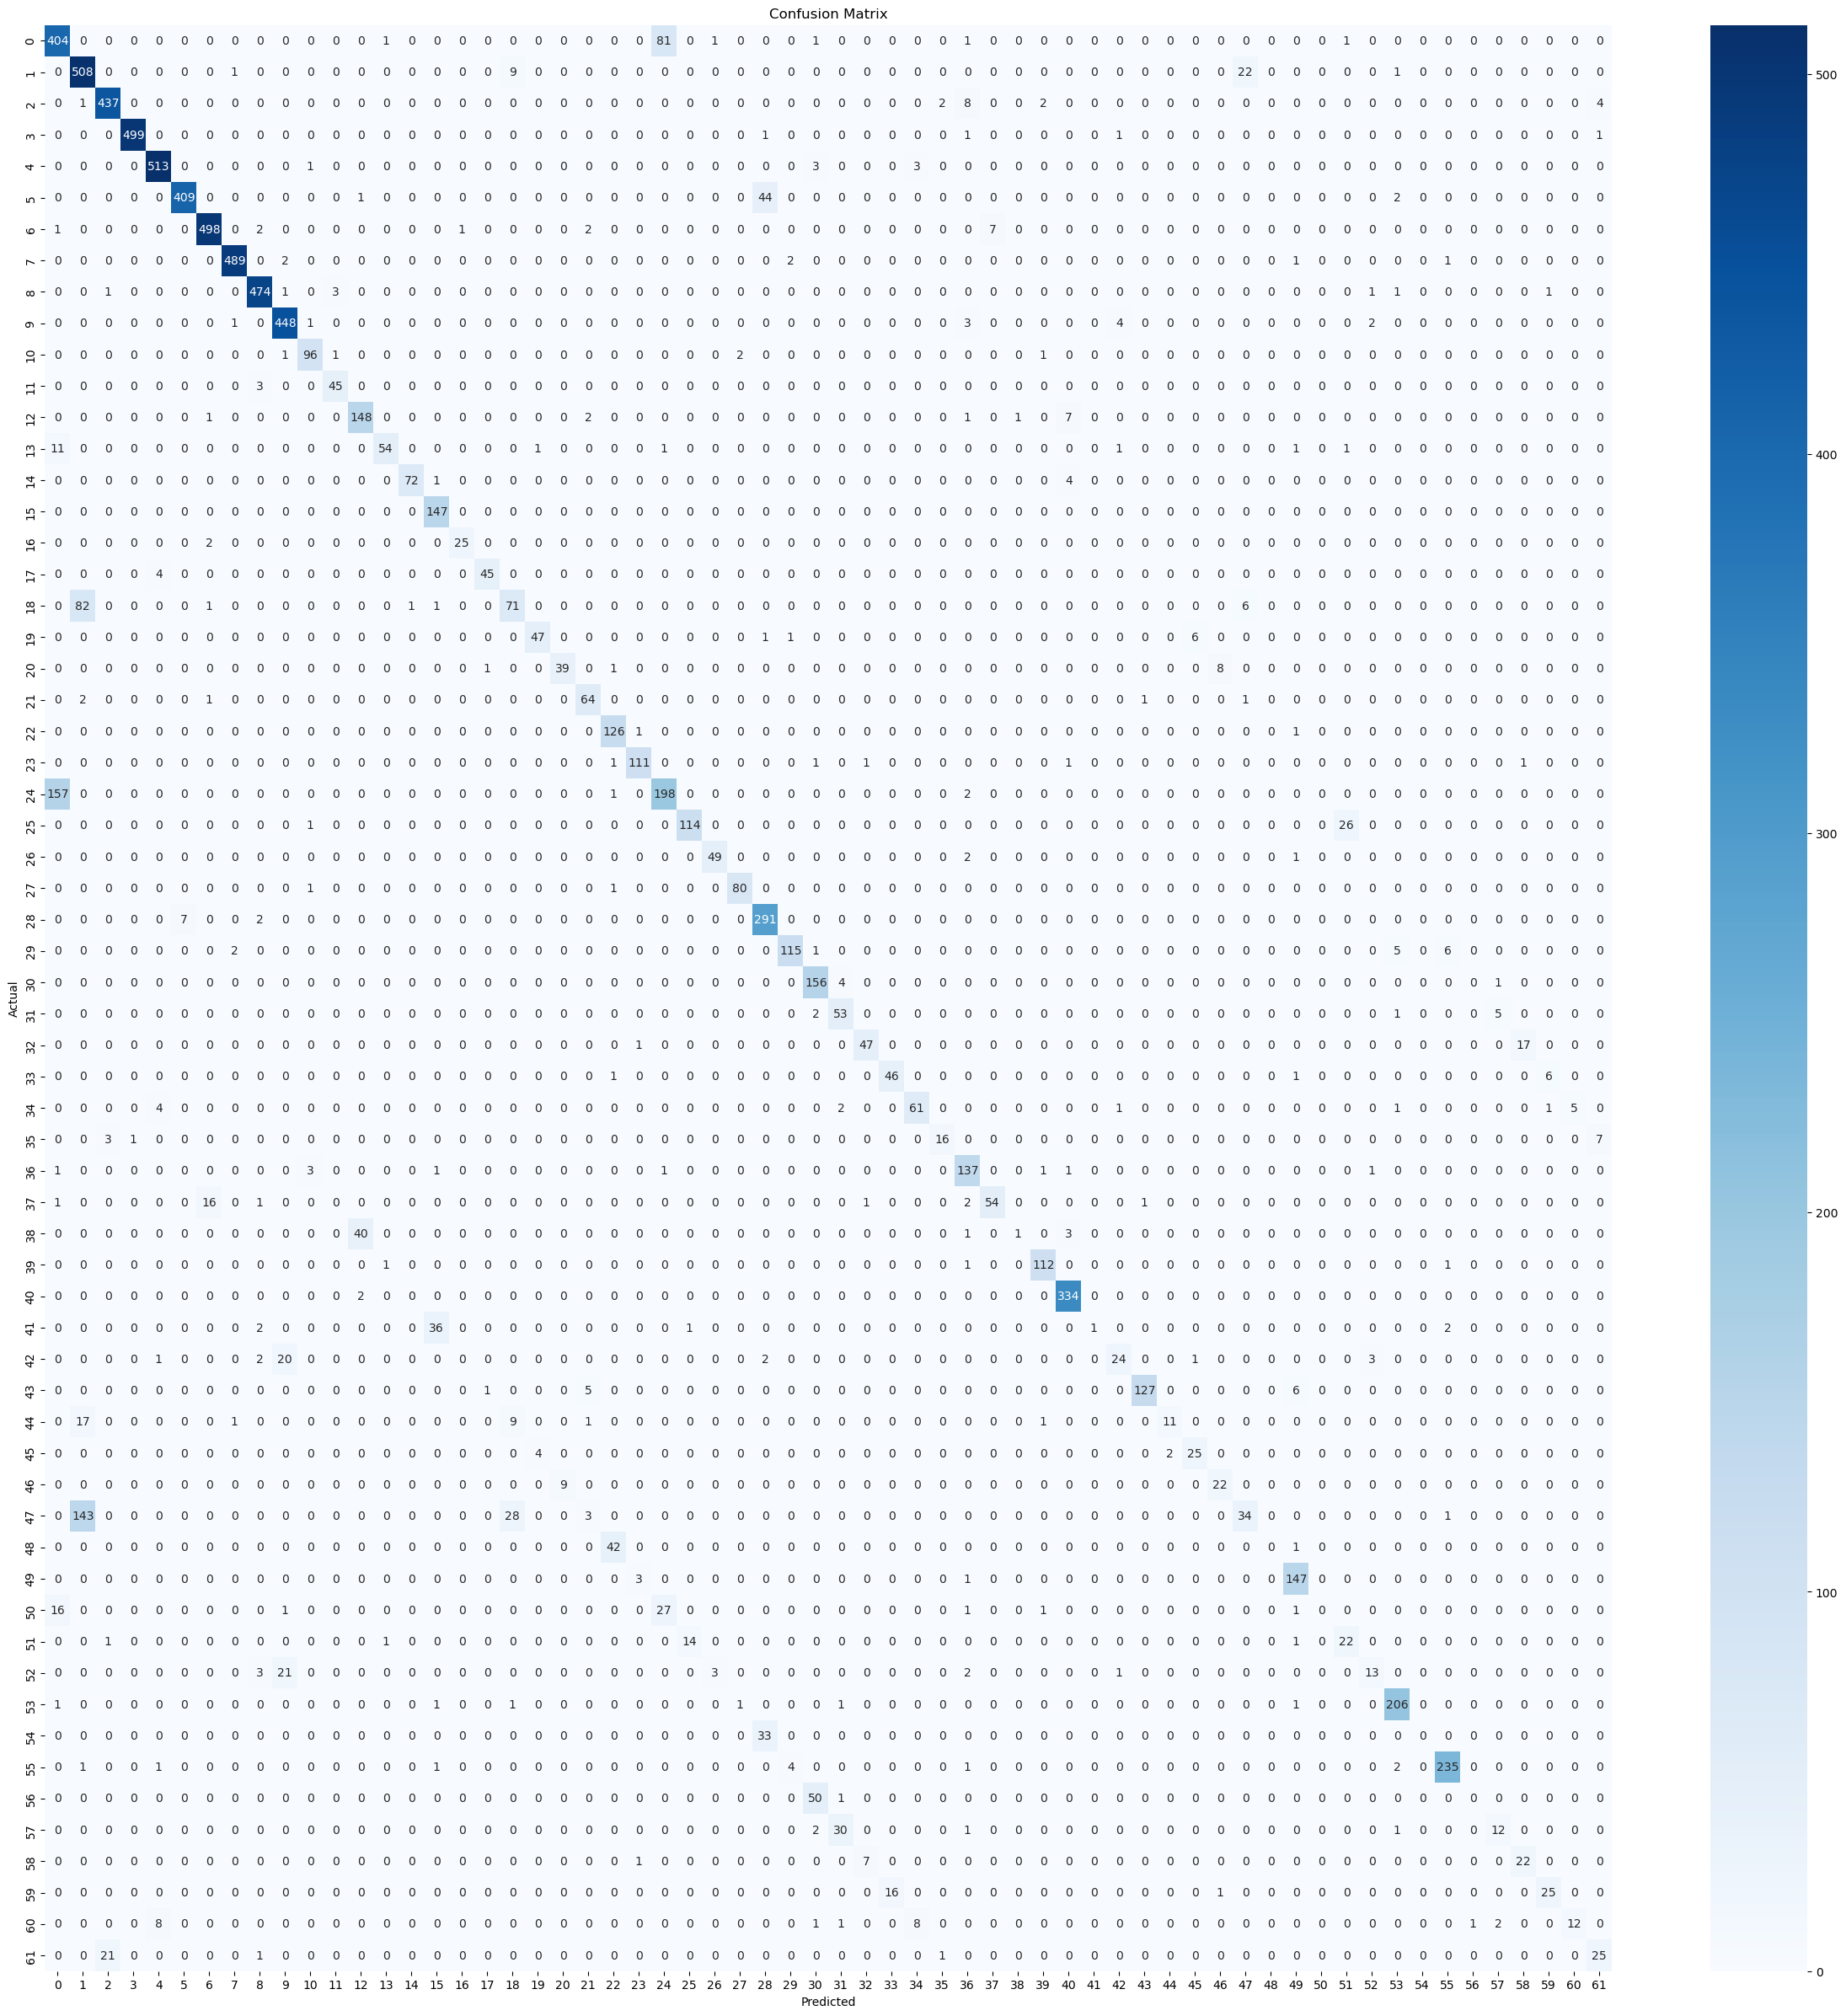

In [19]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# build ResNet model with the best parameters
best_ResNet = build_ResNet14(input_shape = (28, 28, 1), num_classes = 62,
                                         dropout = 0.3, learning_rate = 0.001)
# train the model
history1 = best_ResNet.fit(X_train_scaled, y_train,
                        validation_data = (X_validation_scaled, y_validation),
                          epochs = 20, batch_size = 256, verbose = 1)
# Evaluate model on the validation set
predicted1 = best_ResNet.predict(X_validation_scaled)
report1 = classification_report(y_validation, predicted1.argmax(axis = 1),
                                       zero_division = 0, output_dict = True)
draw_table_classification_report(report1)
conf_matrix = confusion_matrix(y_validation, predicted1.argmax(axis = 1))
plot_confusion_matrix(y_validation, predicted1.argmax(axis = 1))

### 4.1.2 Simple CNN evaluation on the validation dataset
Evaluate the Simple CNN architecture on the validation dataset.

Epoch 1/20
1407/1407 [==============================] - 7s 4ms/step - loss: 1.2601 - accuracy: 0.6469 - val_loss: 0.7324 - val_accuracy: 0.7723
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8386 - accuracy: 0.7405 - val_loss: 0.6525 - val_accuracy: 0.7873
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7629 - accuracy: 0.7584 - val_loss: 0.6233 - val_accuracy: 0.7963
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7228 - accuracy: 0.7690 - val_loss: 0.6107 - val_accuracy: 0.8017
Epoch 5/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6894 - accuracy: 0.7772 - val_loss: 0.5917 - val_accuracy: 0.8064
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6632 - accuracy: 0.7819 - val_loss: 0.5732 - val_accuracy: 0.8102
Epoch 7/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6437 - accuracy: 0.7887 - val_loss: 0.5561 - val_accuracy:

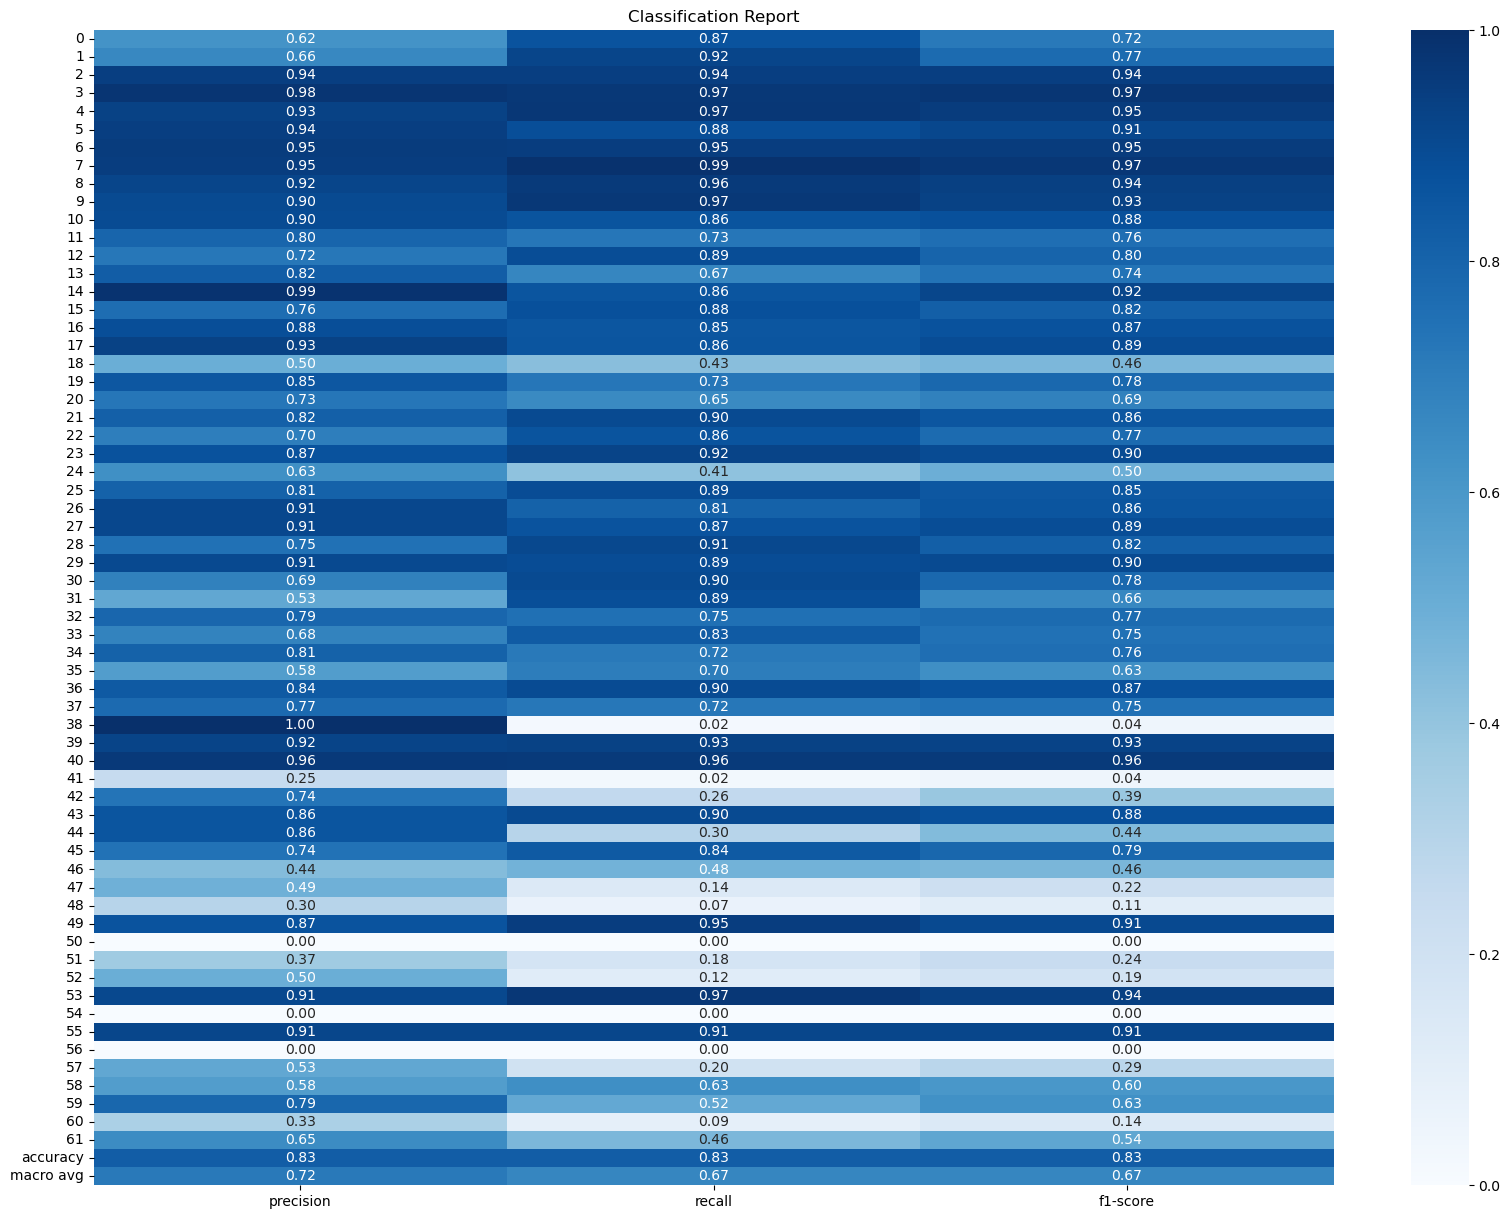

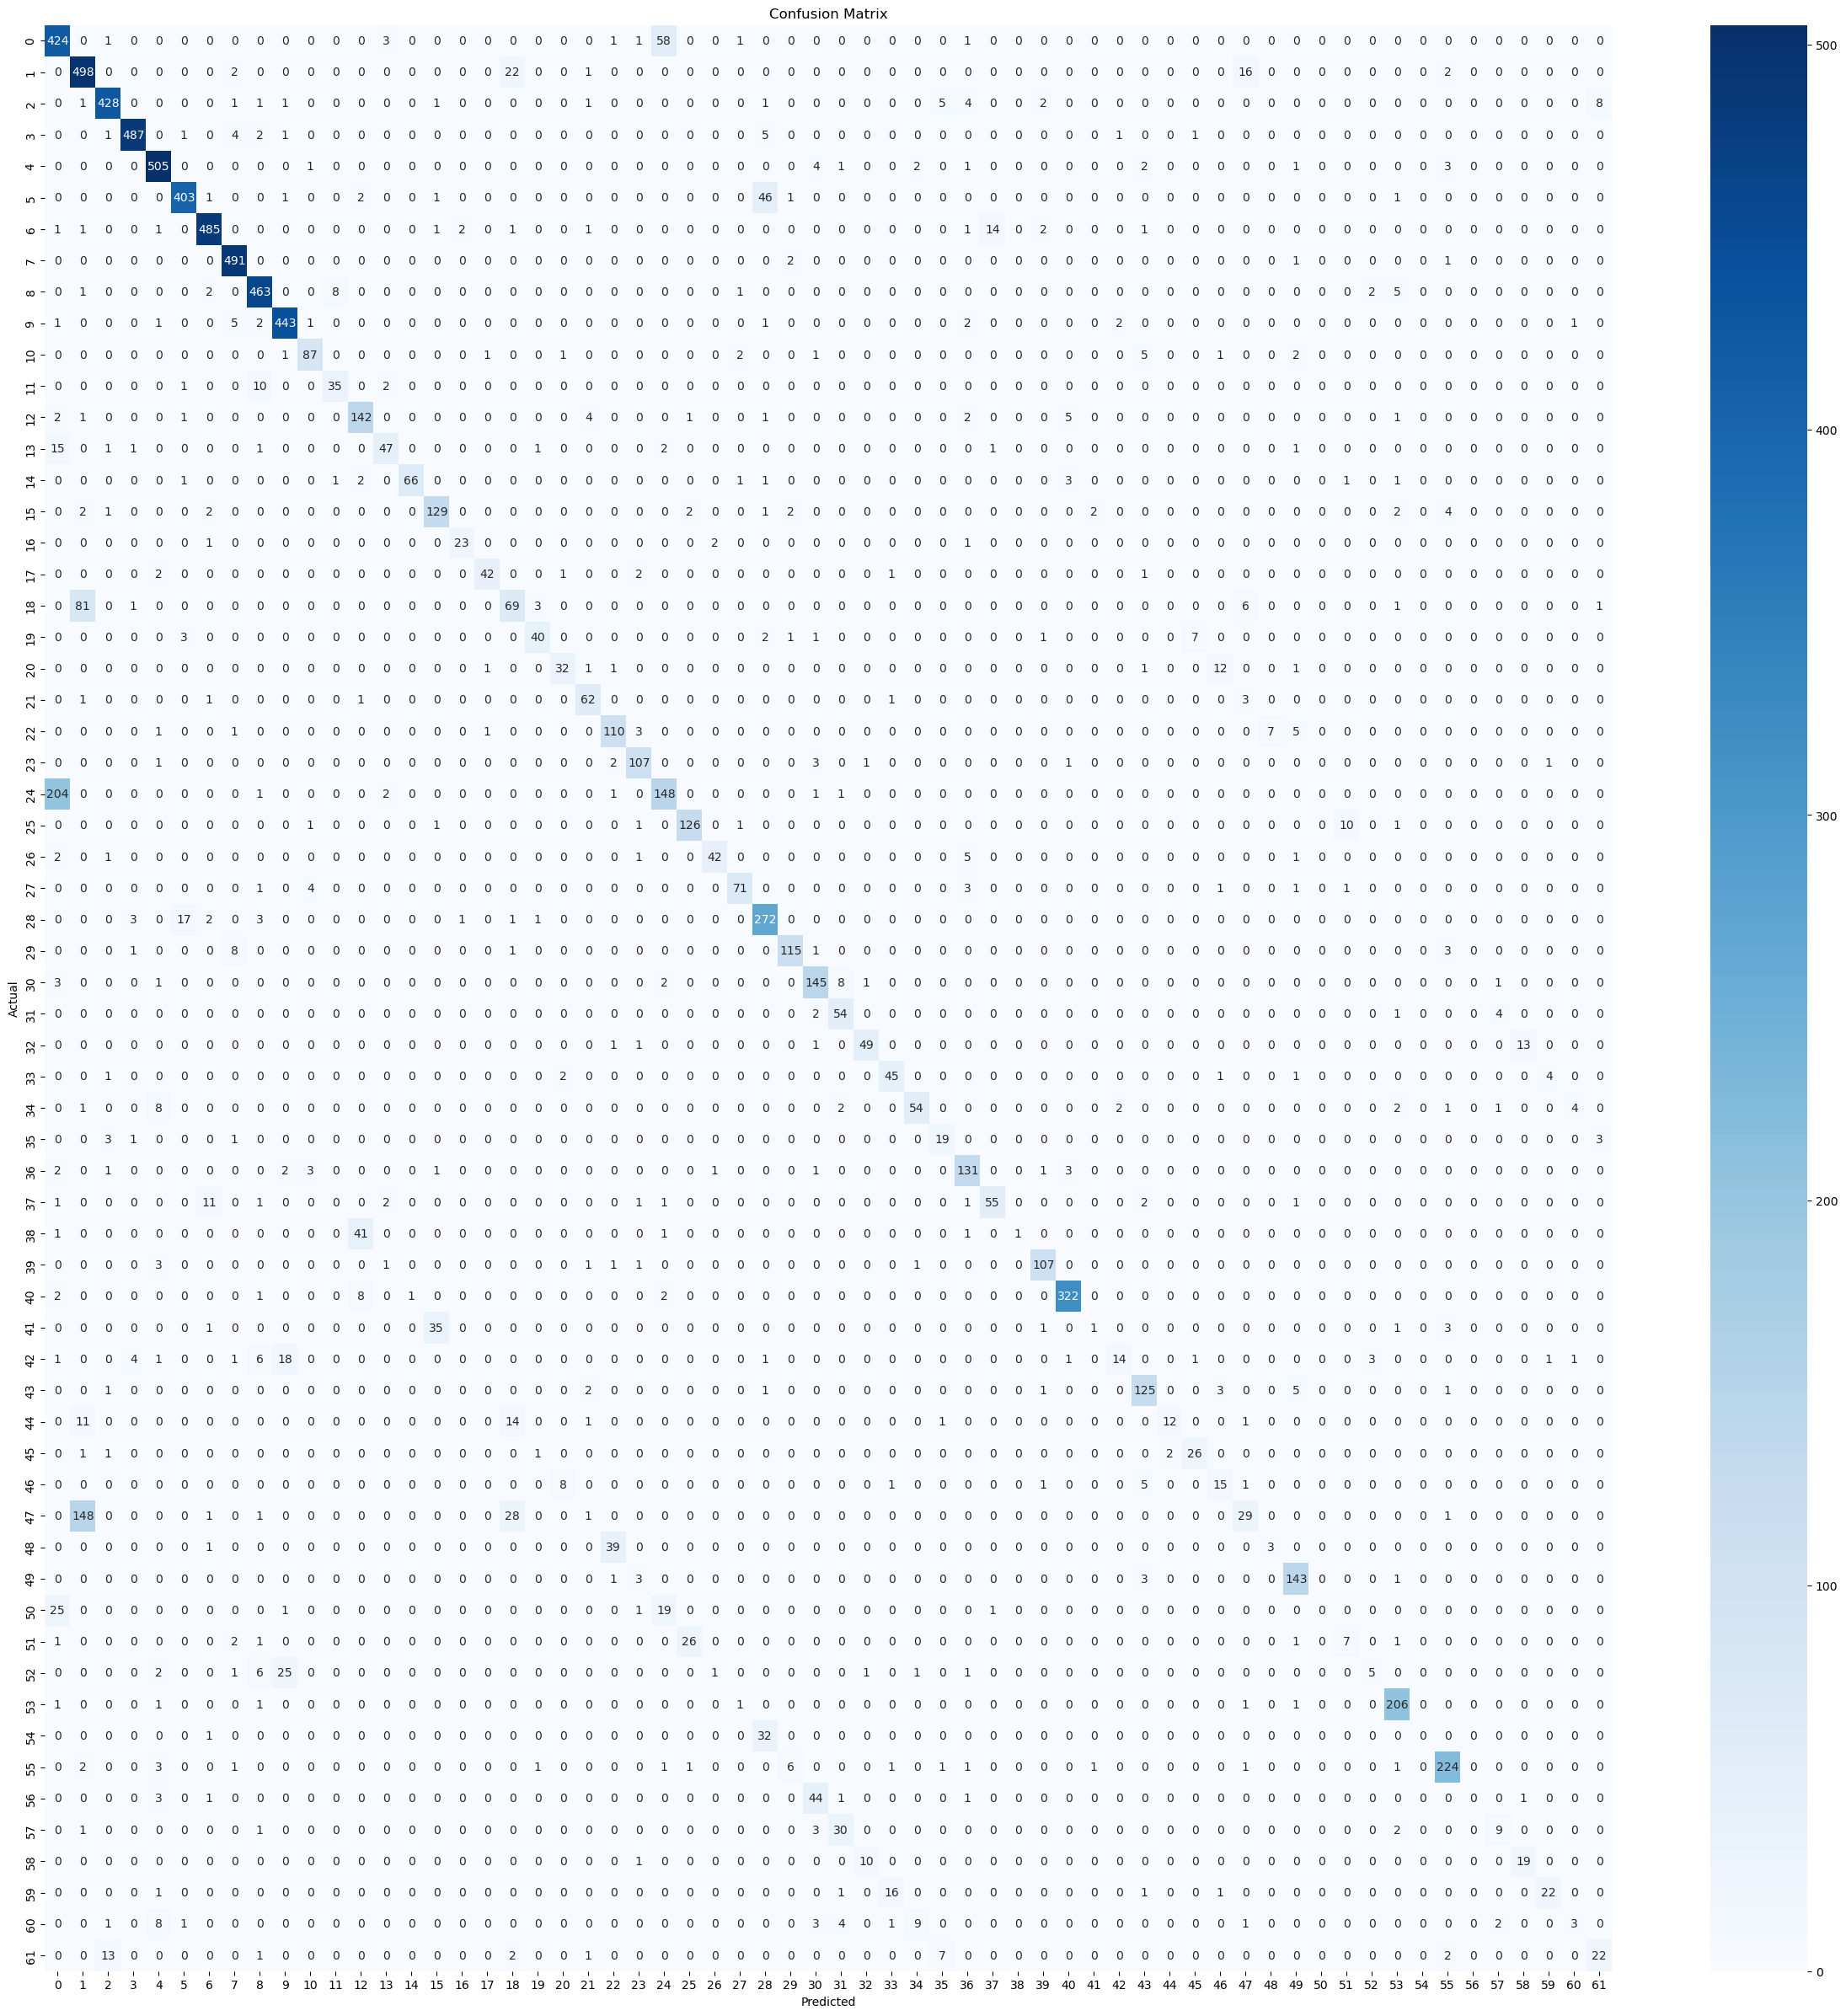

In [20]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# build simpe CNN model with the best parameters
best_CNN = build_CNN(learning_rate = 0.001, dropout = 0.3)
history2 = best_CNN.fit(X_train_scaled, y_train,
                        validation_data = (X_validation_scaled, y_validation),
                         epochs = 20, batch_size = 64, verbose = 1)
# Evaluate model on the validation set
predicted2 = best_CNN.predict(X_validation_scaled)
report2 = classification_report(y_validation, predicted2.argmax(axis = 1),
                                       zero_division = 0, output_dict = True)
draw_table_classification_report(report2)
conf_matrix = confusion_matrix(y_validation, predicted2.argmax(axis = 1))
plot_confusion_matrix(y_validation, predicted2.argmax(axis = 1))

### 4.1.3 EfficientNet-like evaluation on the validation dataset
Evaluate the EfficientNet-like architecture on the validation dataset.

Epoch 1/20
704/704 [==============================] - 21s 23ms/step - loss: 0.8323 - accuracy: 0.7408 - val_loss: 0.7555 - val_accuracy: 0.7555
Epoch 2/20
704/704 [==============================] - 16s 22ms/step - loss: 0.5108 - accuracy: 0.8220 - val_loss: 0.5618 - val_accuracy: 0.8171
Epoch 3/20
704/704 [==============================] - 16s 22ms/step - loss: 0.4646 - accuracy: 0.8346 - val_loss: 0.5213 - val_accuracy: 0.8215
Epoch 4/20
704/704 [==============================] - 16s 22ms/step - loss: 0.4345 - accuracy: 0.8430 - val_loss: 0.4777 - val_accuracy: 0.8379
Epoch 5/20
704/704 [==============================] - 16s 23ms/step - loss: 0.4139 - accuracy: 0.8500 - val_loss: 0.5249 - val_accuracy: 0.8232
Epoch 6/20
704/704 [==============================] - 16s 23ms/step - loss: 0.4043 - accuracy: 0.8531 - val_loss: 0.4795 - val_accuracy: 0.8260
Epoch 7/20
704/704 [==============================] - 17s 24ms/step - loss: 0.3878 - accuracy: 0.8563 - val_loss: 0.5344 - val_accuracy:

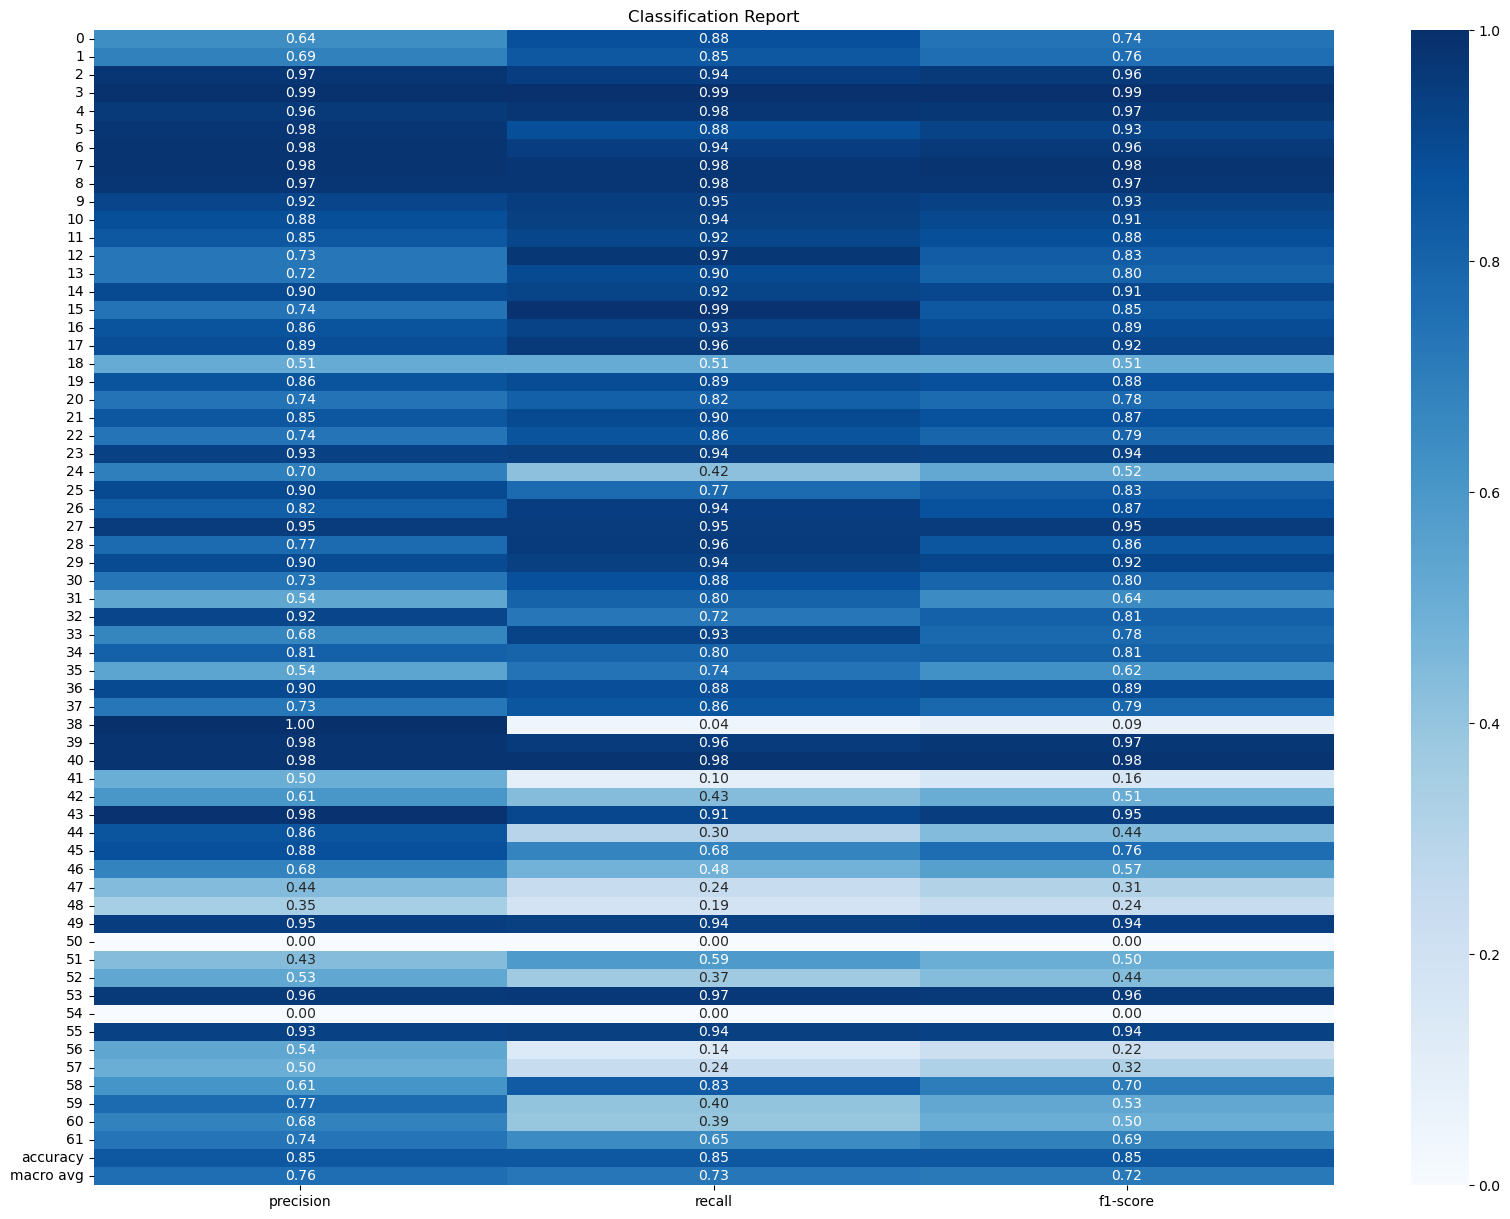

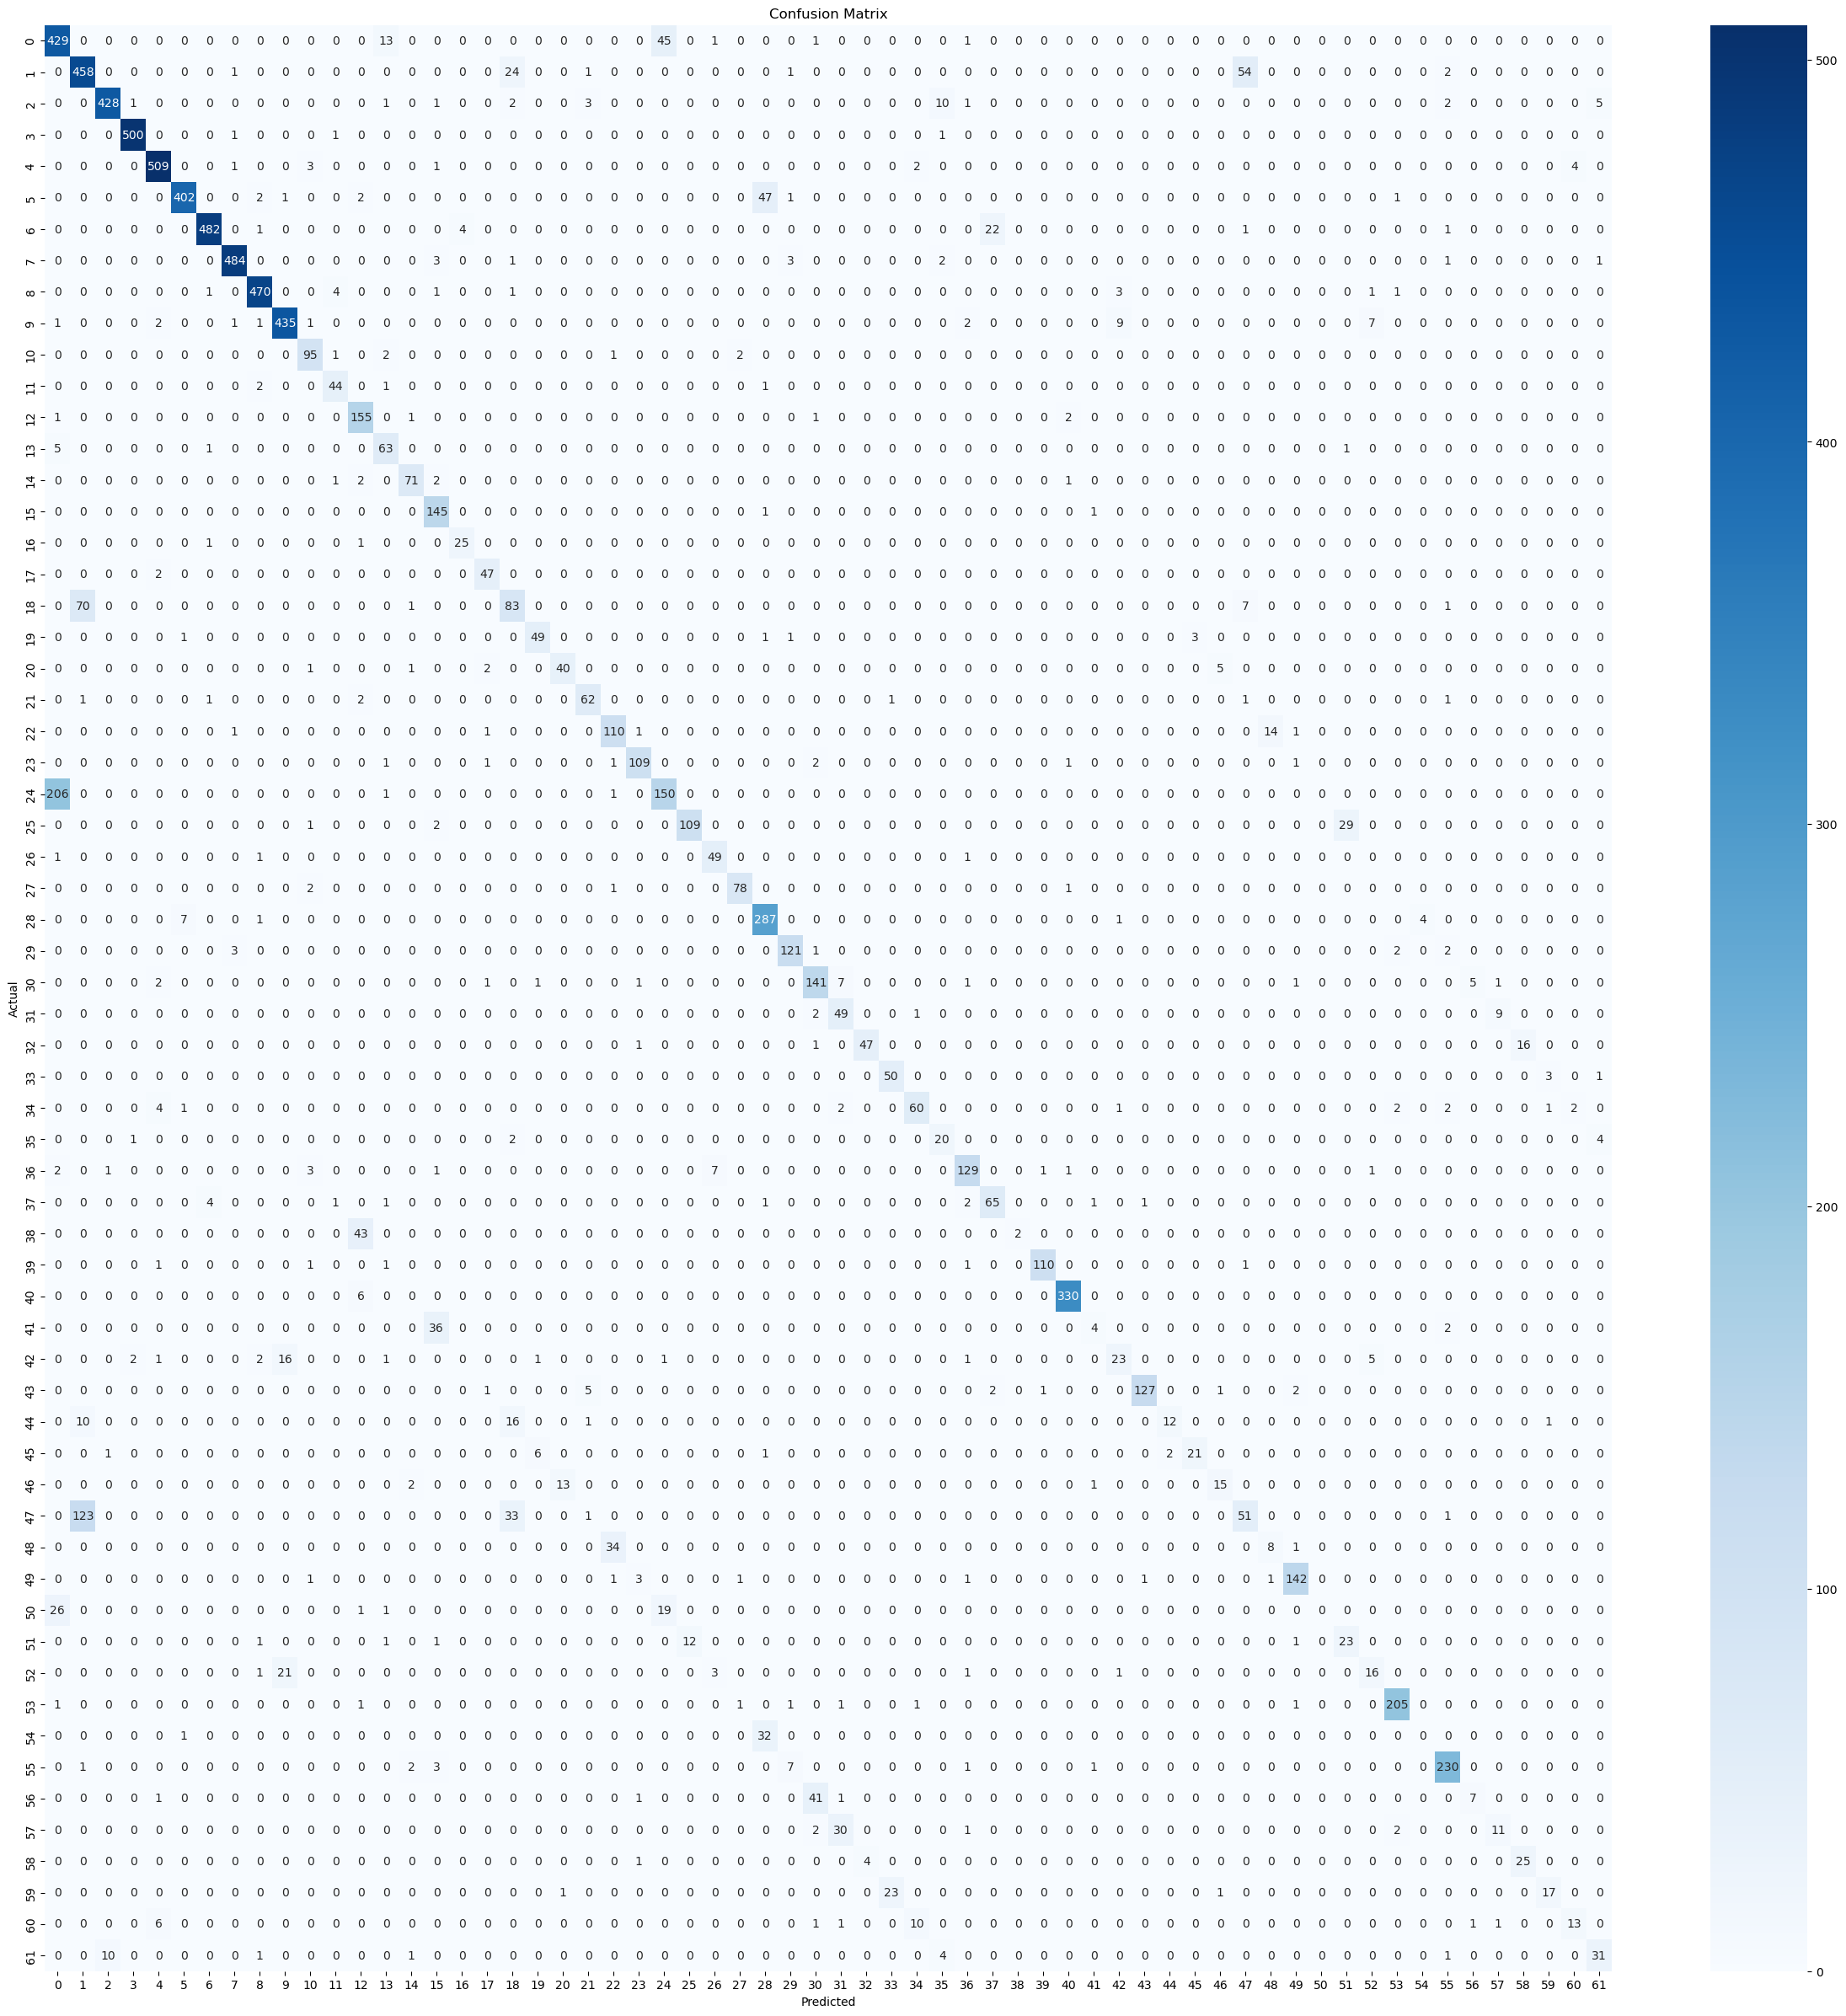

In [21]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# build EfficientNet model with the best parameters
best_EfficientNet = build_efficientnet_like(learning_rate = 0.001,
                                    survival_prob = 0.8, num_classes = 62)
# train the model
history3 = best_EfficientNet.fit(X_train_scaled, y_train,
                        validation_data = (X_validation_scaled, y_validation),
                              epochs = 20, batch_size = 128, verbose = 1)
# Evaluate model on the validation set
predicted3 = best_EfficientNet.predict(X_validation_scaled)
report3 = classification_report(y_validation, predicted3.argmax(axis = 1),
                         zero_division = 0,output_dict = True)
draw_table_classification_report(report3)
conf_matrix = confusion_matrix(y_validation, predicted3.argmax(axis = 1))
plot_confusion_matrix(y_validation, predicted3.argmax(axis=1))


## 4.2 Evaluation on the test dataset
Evaluate the model performance on the test dataset.
### 4.2.1 ResNet-like evaluation on the test dataset
Evaluate the ResNet-like architecture on the test dataset.

Epoch 1/20
352/352 [==============================] - 7s 15ms/step - loss: 1.1647 - accuracy: 0.6739 - val_loss: 4.8084 - val_accuracy: 0.1299
Epoch 2/20
352/352 [==============================] - 5s 15ms/step - loss: 0.5786 - accuracy: 0.8036 - val_loss: 0.7865 - val_accuracy: 0.7529
Epoch 3/20
352/352 [==============================] - 5s 14ms/step - loss: 0.5024 - accuracy: 0.8243 - val_loss: 0.5322 - val_accuracy: 0.8233
Epoch 4/20
352/352 [==============================] - 6s 16ms/step - loss: 0.4640 - accuracy: 0.8353 - val_loss: 0.5153 - val_accuracy: 0.8175
Epoch 5/20
352/352 [==============================] - 5s 14ms/step - loss: 0.4417 - accuracy: 0.8416 - val_loss: 0.4381 - val_accuracy: 0.8462
Epoch 6/20
352/352 [==============================] - 5s 14ms/step - loss: 0.4271 - accuracy: 0.8449 - val_loss: 0.4326 - val_accuracy: 0.8426
Epoch 7/20
352/352 [==============================] - 5s 13ms/step - loss: 0.4140 - accuracy: 0.8494 - val_loss: 0.4182 - val_accuracy: 0.8544

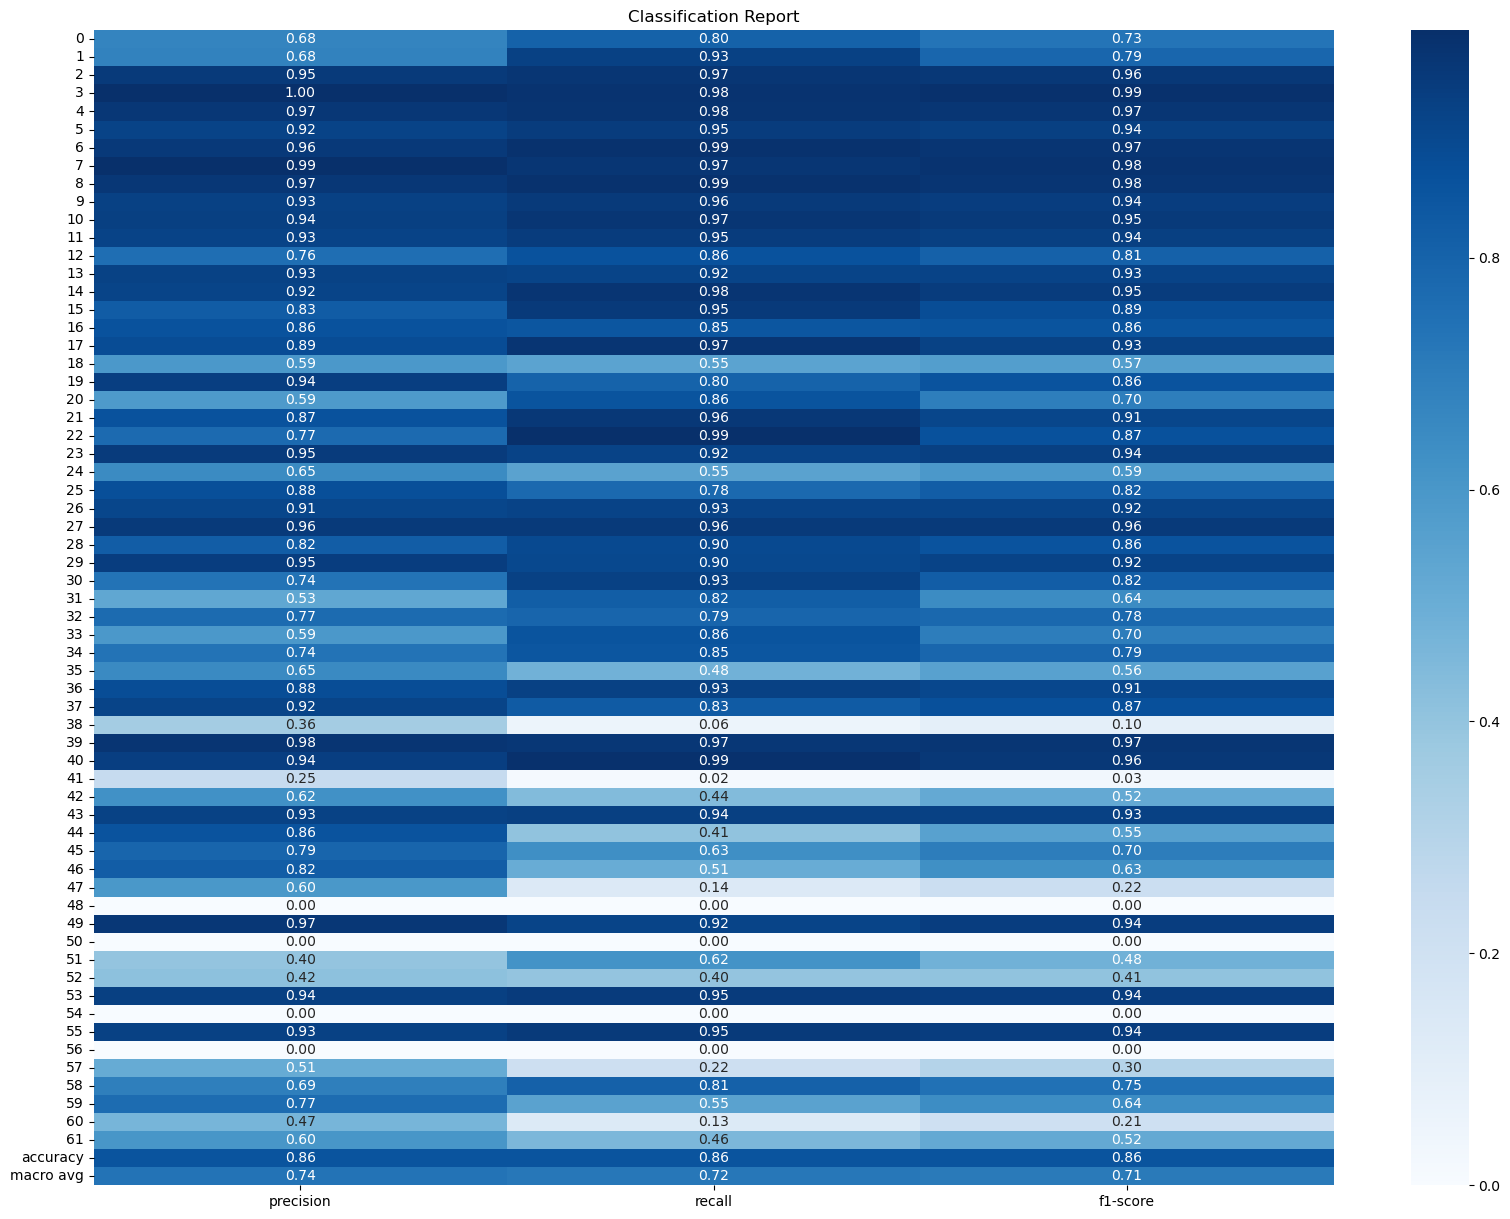

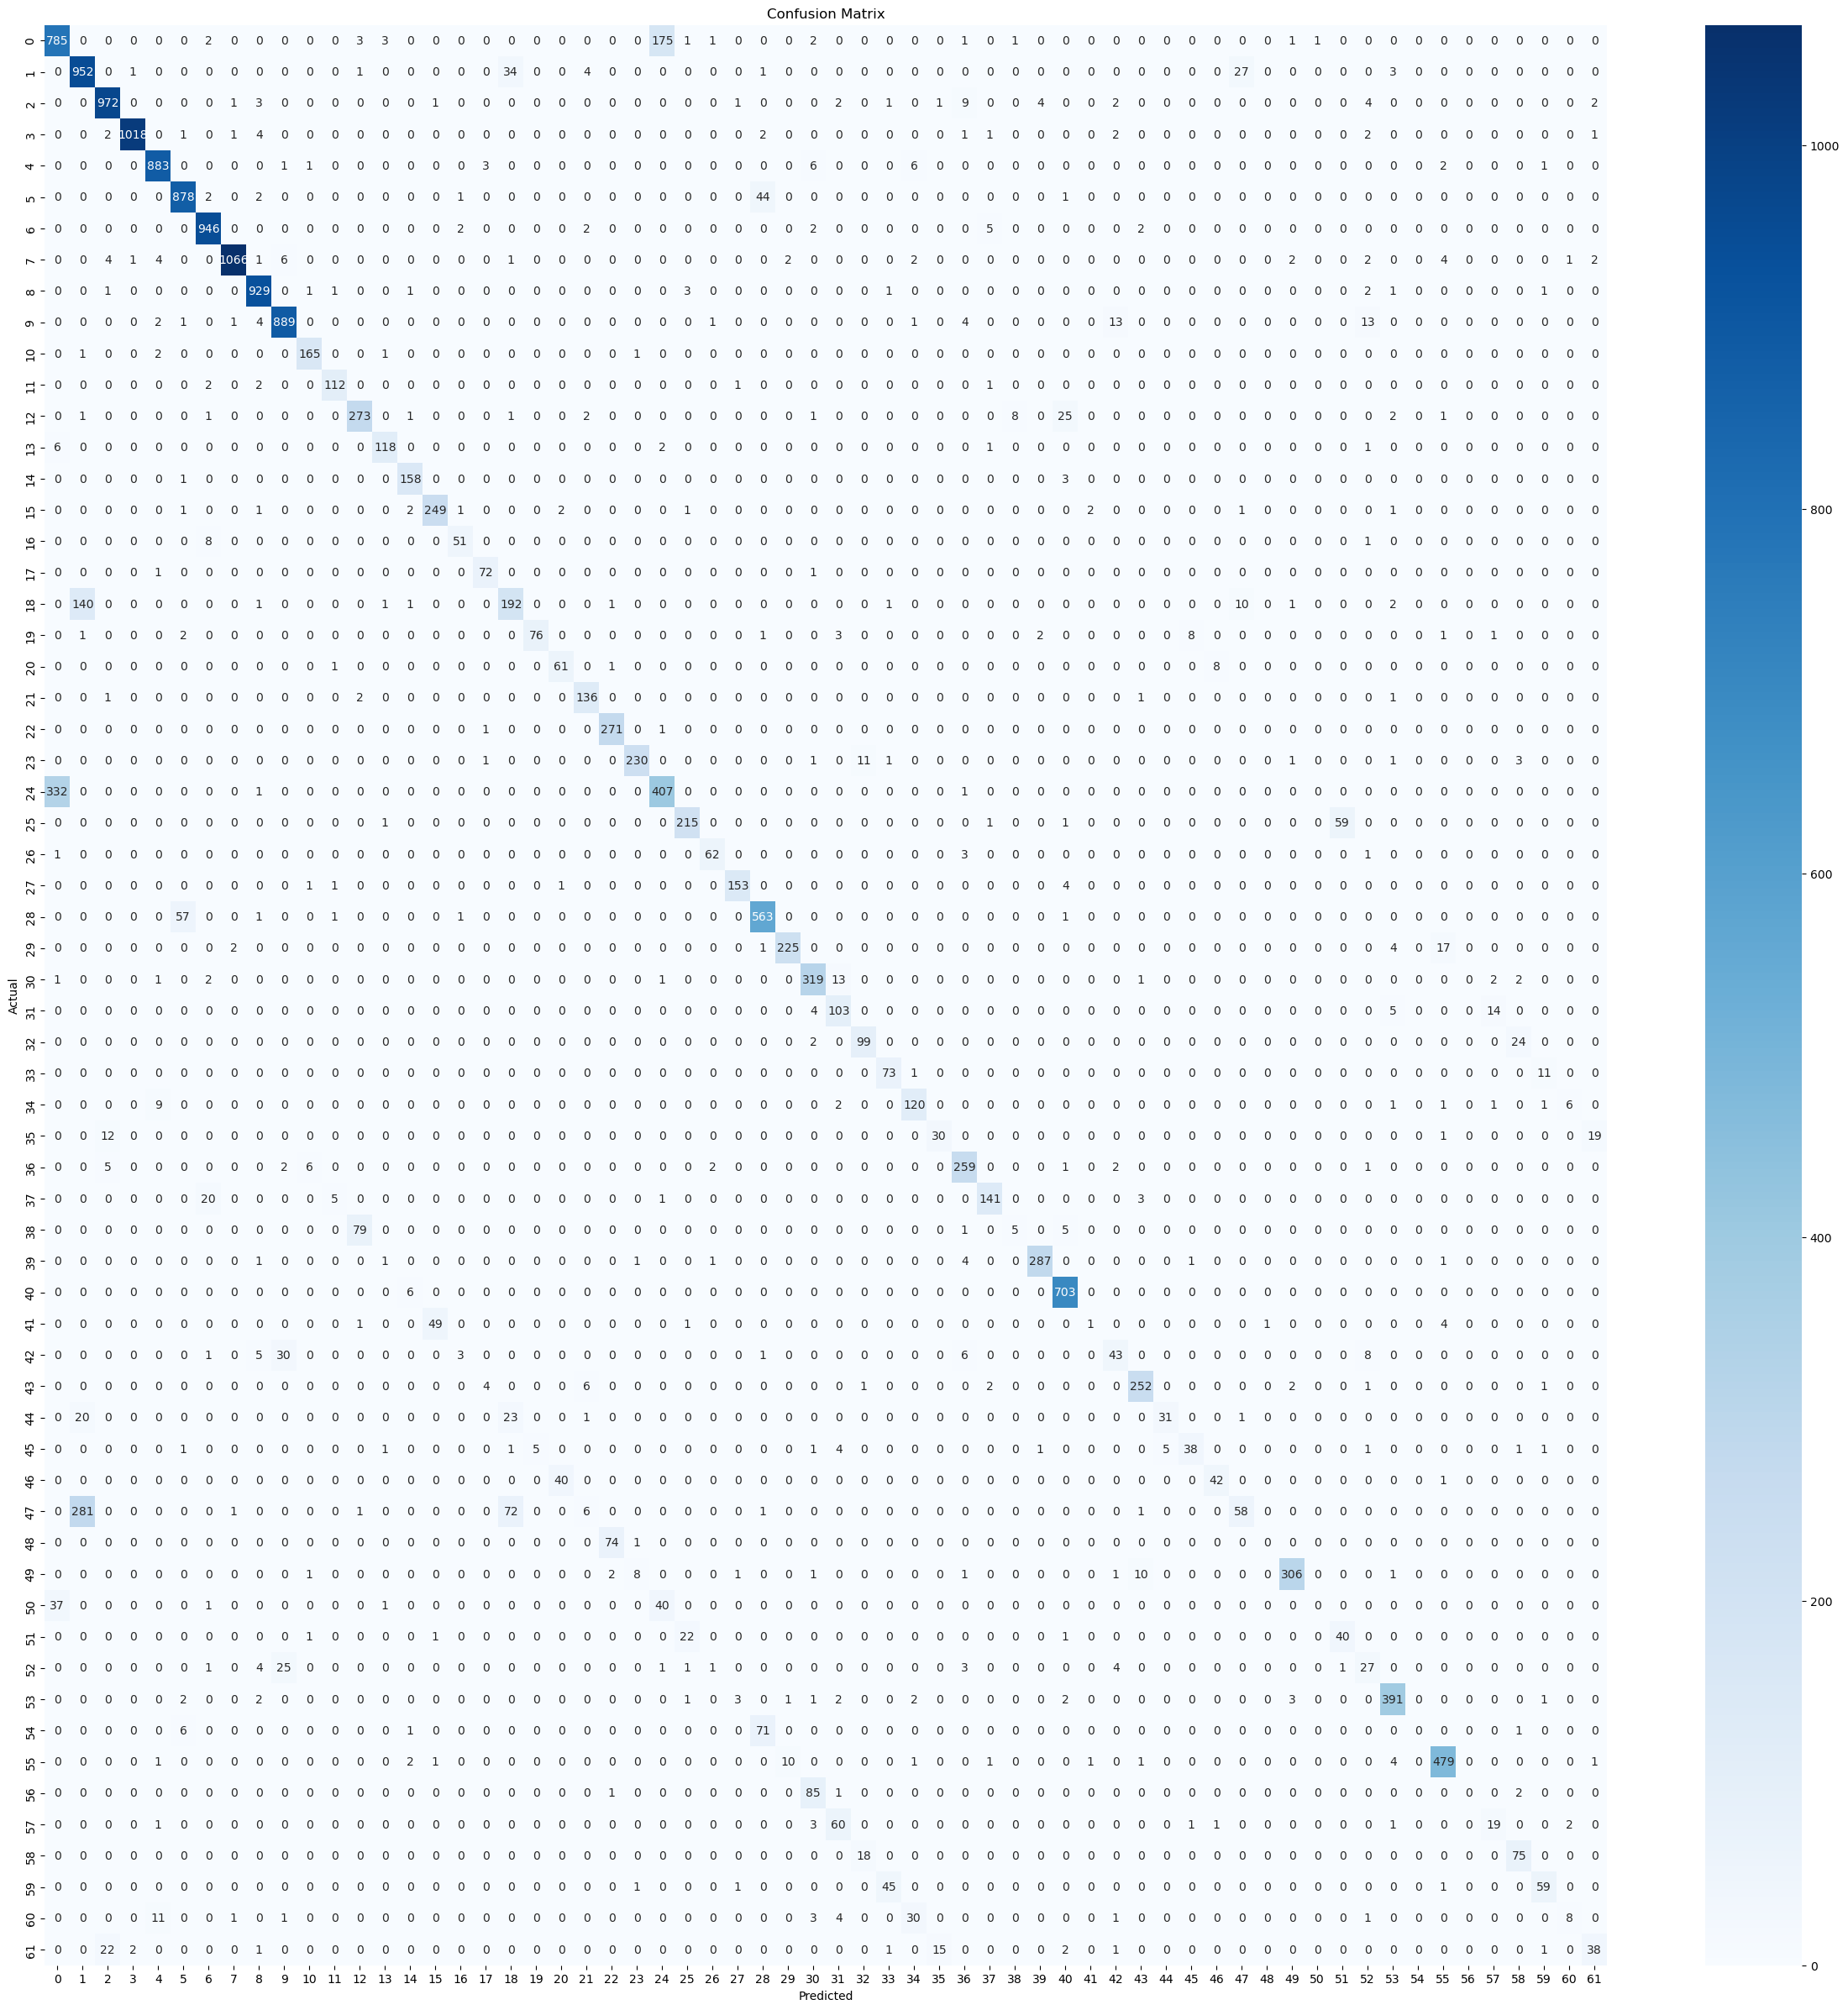

In [22]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# build ResNet model with the best parameters
best_ResNet = build_ResNet14(input_shape = (28, 28, 1), num_classes = 62,
                                        dropout = 0.3, learning_rate = 0.001)
# train the model
history1 = best_ResNet.fit(X_train_scaled, y_train,
                        validation_data = (X_validation_scaled, y_validation),
                          epochs = 20, batch_size = 256, verbose = 1)
# Evaluate model on the test set
predicted1 = best_ResNet.predict(X_test_scaled)
report1 = classification_report(y_test, predicted1.argmax(axis = 1),
                                        zero_division = 0,output_dict = True)
draw_table_classification_report(report1)
conf_matrix = confusion_matrix(y_test, predicted1.argmax(axis = 1))
plot_confusion_matrix(y_test, predicted1.argmax(axis = 1))

### 4.2.2 Simple CNN evaluation on the test dataset
Evaluate the Simple CNN architecture on the test dataset.

Epoch 1/20
1407/1407 [==============================] - 7s 4ms/step - loss: 1.2619 - accuracy: 0.6472 - val_loss: 0.7294 - val_accuracy: 0.7739
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8423 - accuracy: 0.7400 - val_loss: 0.6619 - val_accuracy: 0.7871
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7660 - accuracy: 0.7576 - val_loss: 0.6242 - val_accuracy: 0.7965
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7282 - accuracy: 0.7677 - val_loss: 0.6093 - val_accuracy: 0.8005
Epoch 5/20
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6935 - accuracy: 0.7766 - val_loss: 0.6008 - val_accuracy: 0.8051
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6694 - accuracy: 0.7799 - val_loss: 0.5763 - val_accuracy: 0.8095
Epoch 7/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6480 - accuracy: 0.7861 - val_loss: 0.5576 - val_accuracy:

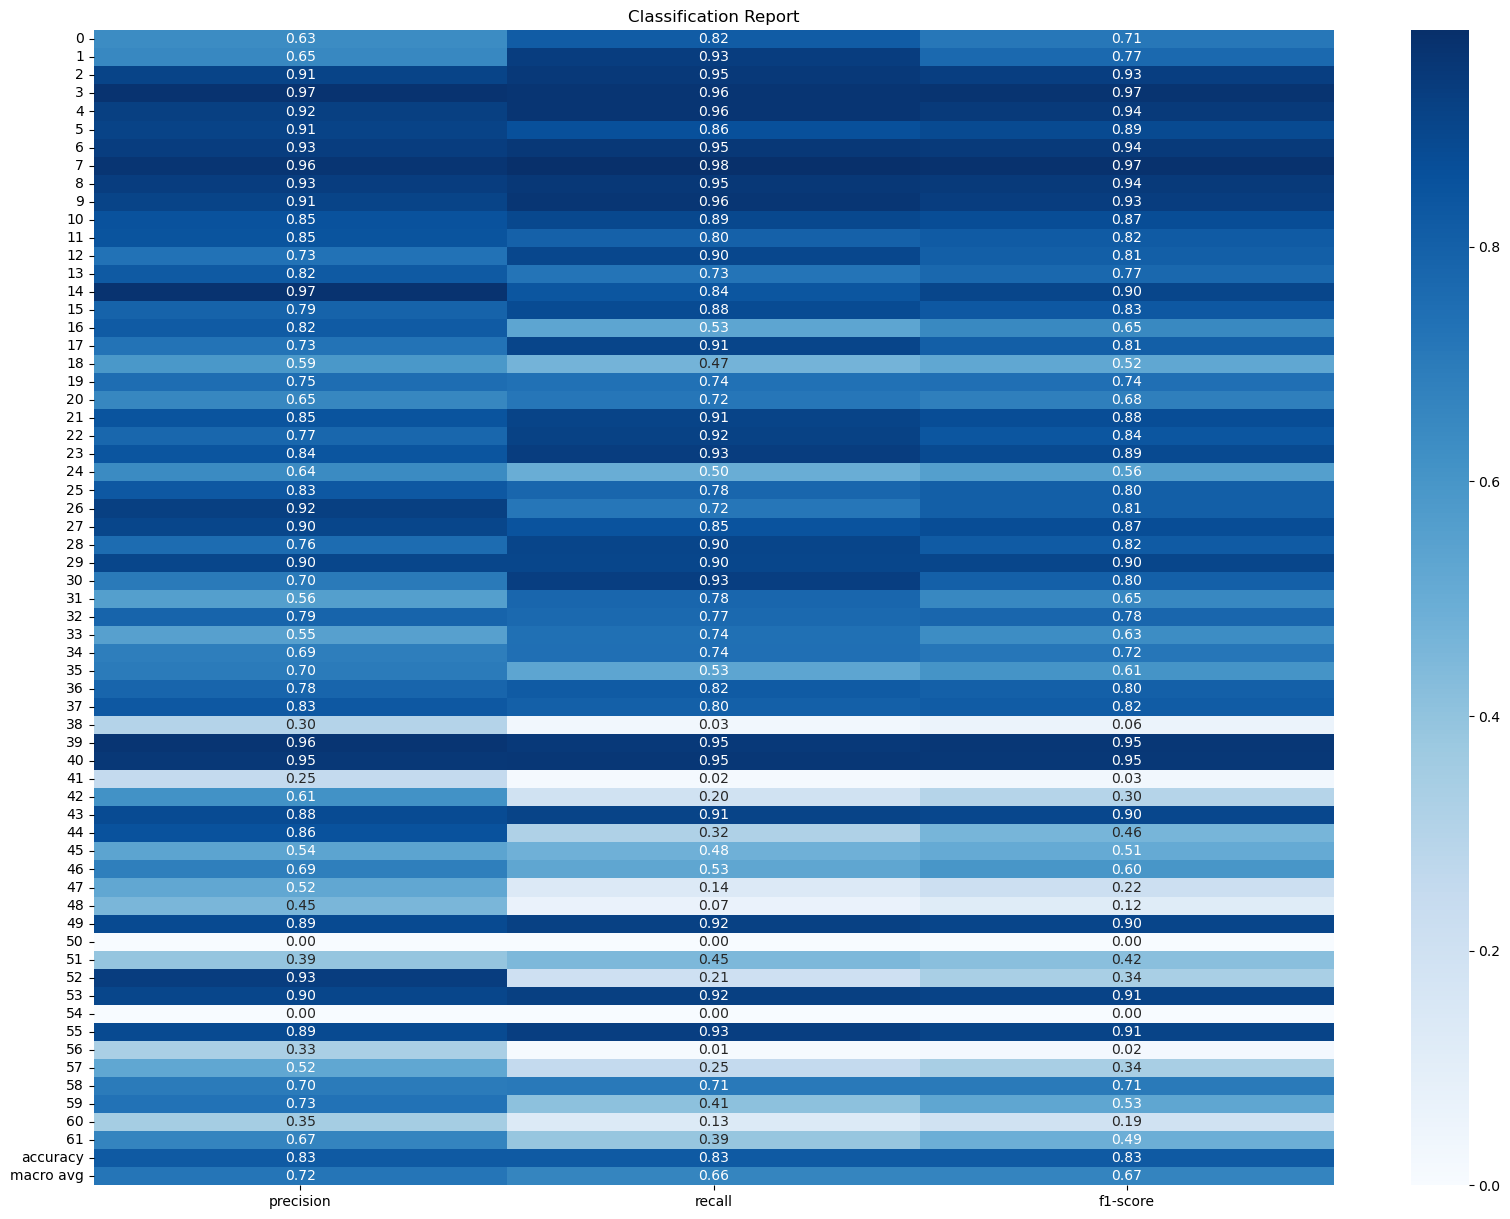

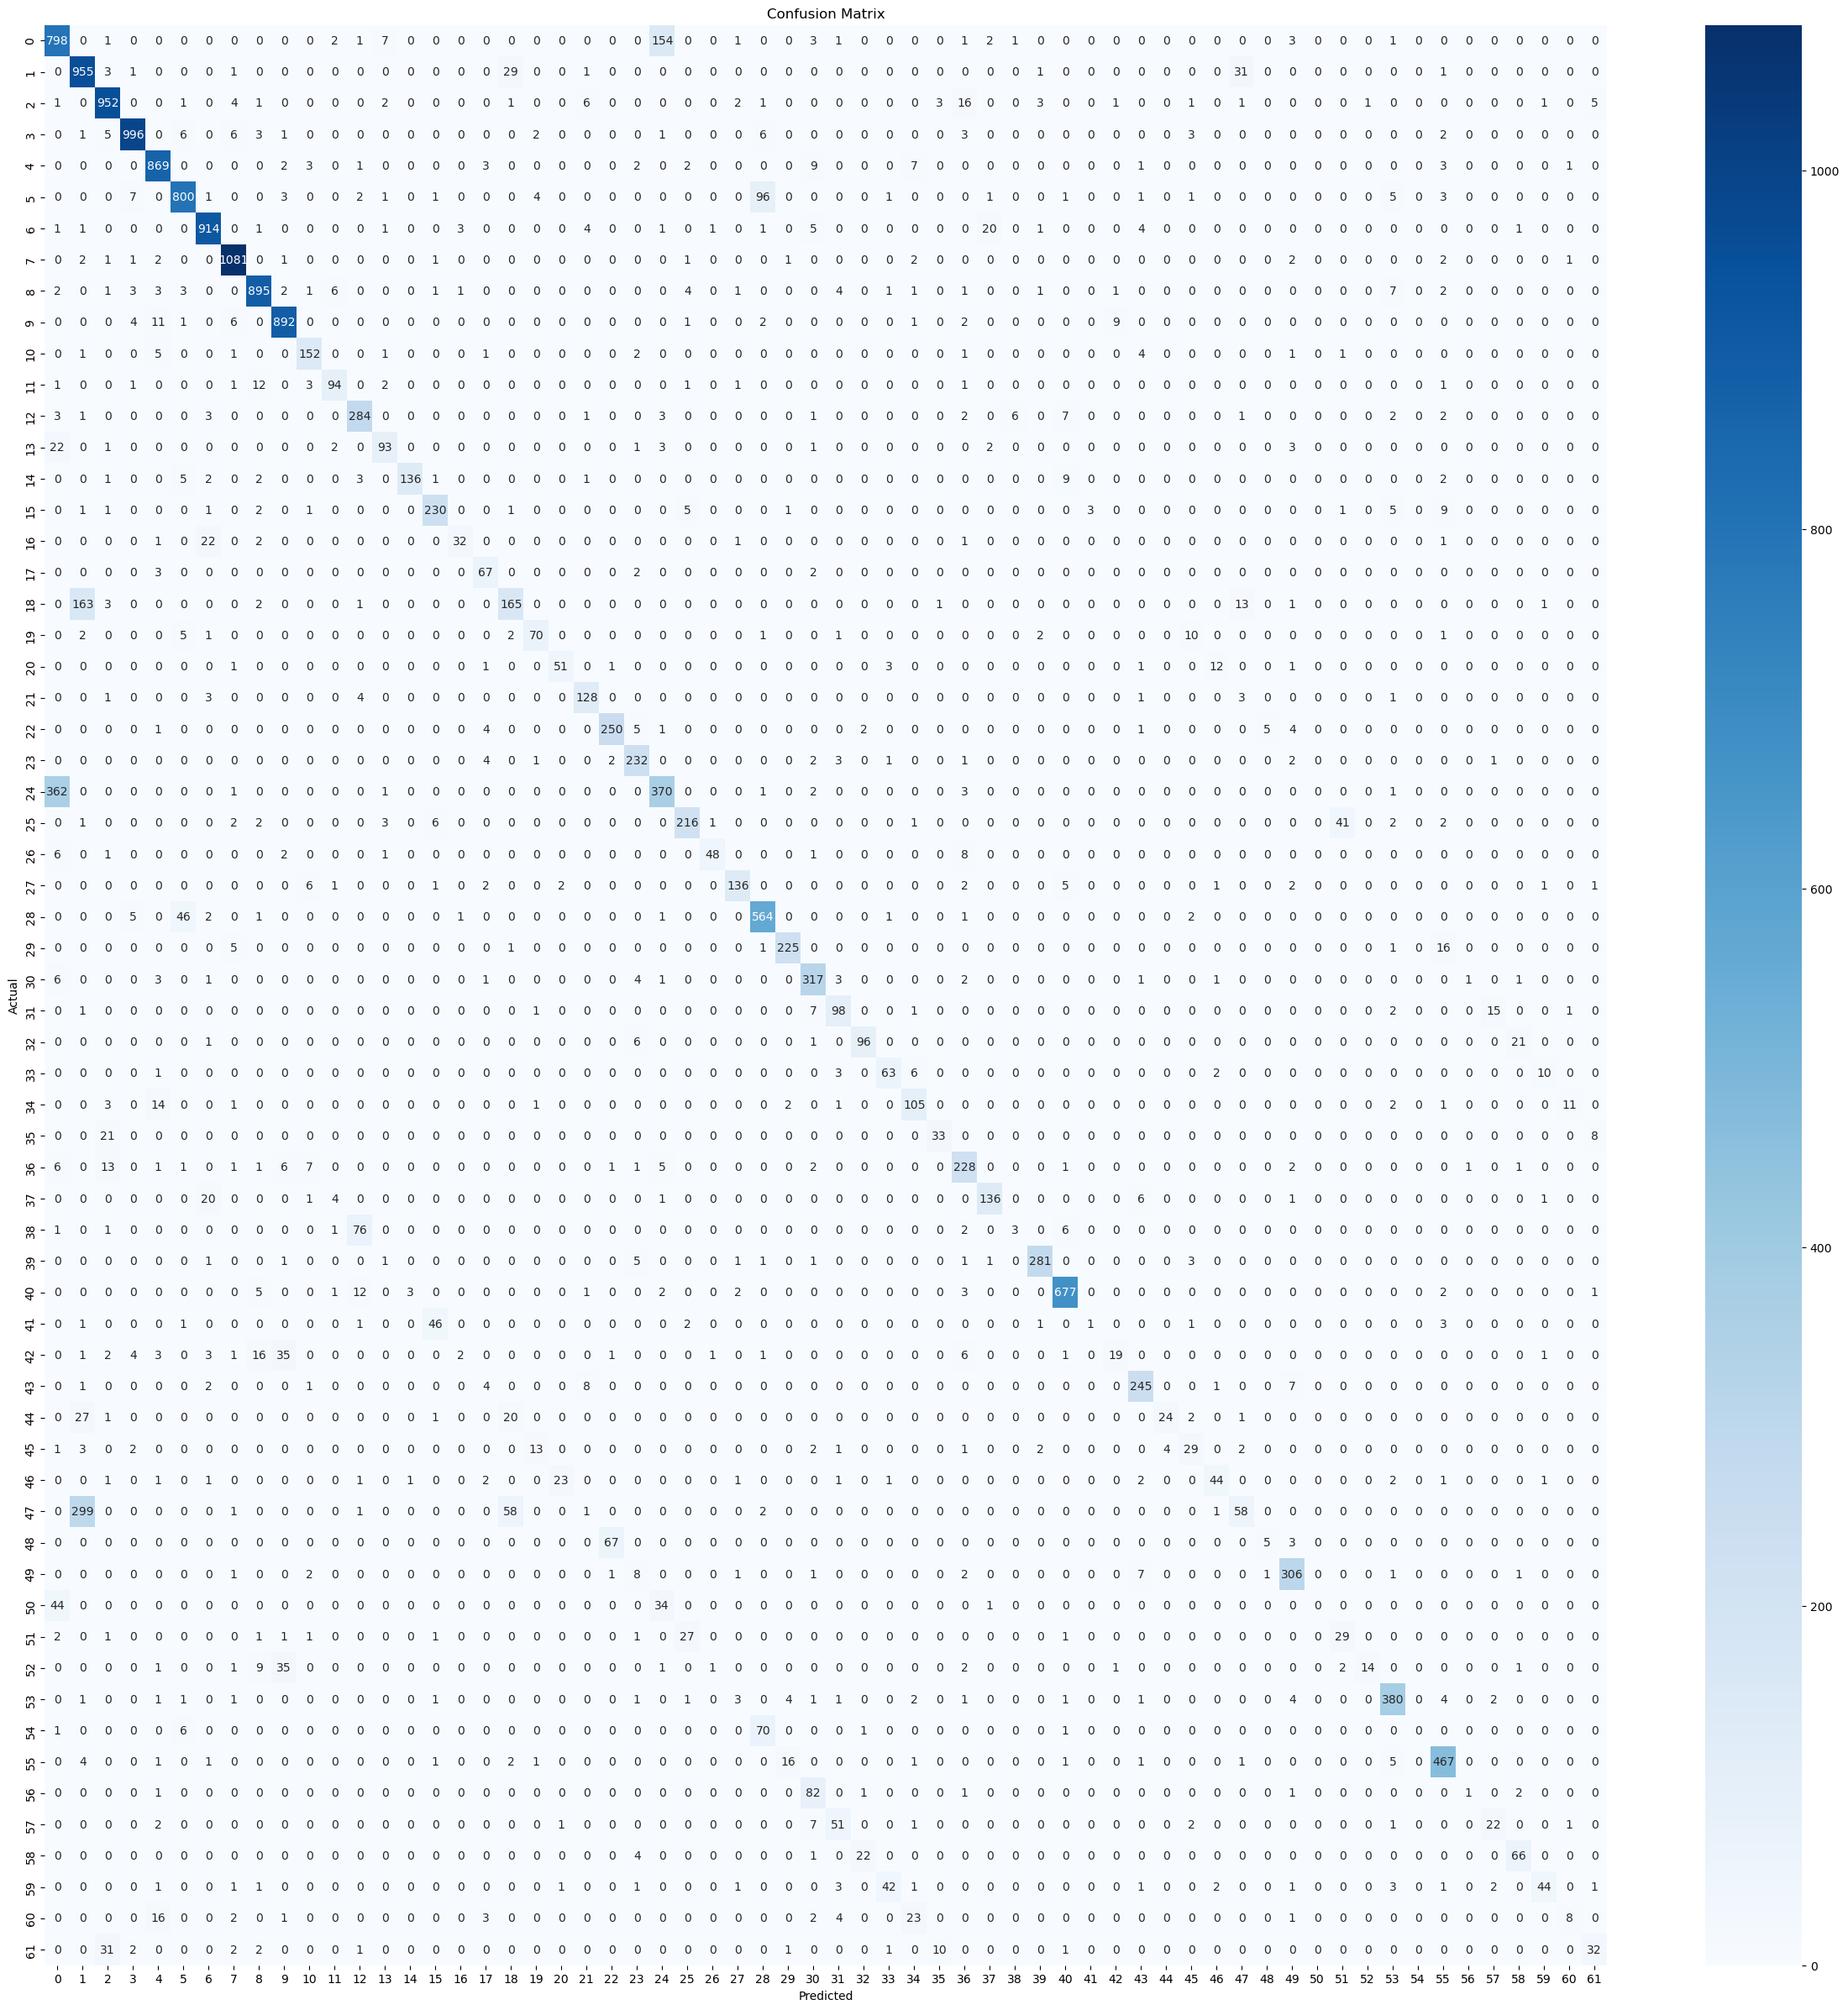

In [23]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# build simpe CNN model with the best parameters
best_CNN = build_CNN(learning_rate = 0.001, dropout = 0.3)
# train the model
history2 = best_CNN.fit(X_train_scaled, y_train,
                        validation_data = (X_validation_scaled, y_validation),
                         epochs = 20, batch_size = 64, verbose = 1)
# Evaluate model on the test set
predicted2 = best_CNN.predict(X_test_scaled)
report2 = classification_report(y_test, predicted2.argmax(axis = 1),
                                        zero_division = 0,output_dict = True)
draw_table_classification_report(report2)
conf_matrix = confusion_matrix(y_test, predicted2.argmax(axis = 1))
plot_confusion_matrix(y_test, predicted2.argmax(axis = 1))

### 4.2.3 EffcientNet-like evaluation on the test dataset
Evaluate the EfficientNet-like architecture on the test dataset.

Epoch 1/20
704/704 [==============================] - 19s 23ms/step - loss: 0.8323 - accuracy: 0.7408 - val_loss: 0.7546 - val_accuracy: 0.7564
Epoch 2/20
704/704 [==============================] - 15s 21ms/step - loss: 0.5109 - accuracy: 0.8220 - val_loss: 0.5615 - val_accuracy: 0.8173
Epoch 3/20
704/704 [==============================] - 15s 21ms/step - loss: 0.4646 - accuracy: 0.8342 - val_loss: 0.5261 - val_accuracy: 0.8199
Epoch 4/20
704/704 [==============================] - 15s 22ms/step - loss: 0.4350 - accuracy: 0.8425 - val_loss: 0.4963 - val_accuracy: 0.8364
Epoch 5/20
704/704 [==============================] - 16s 22ms/step - loss: 0.4102 - accuracy: 0.8507 - val_loss: 0.5293 - val_accuracy: 0.8201
Epoch 6/20
704/704 [==============================] - 15s 21ms/step - loss: 0.4066 - accuracy: 0.8509 - val_loss: 0.4715 - val_accuracy: 0.8319
Epoch 7/20
704/704 [==============================] - 15s 22ms/step - loss: 0.3887 - accuracy: 0.8555 - val_loss: 0.5441 - val_accuracy:

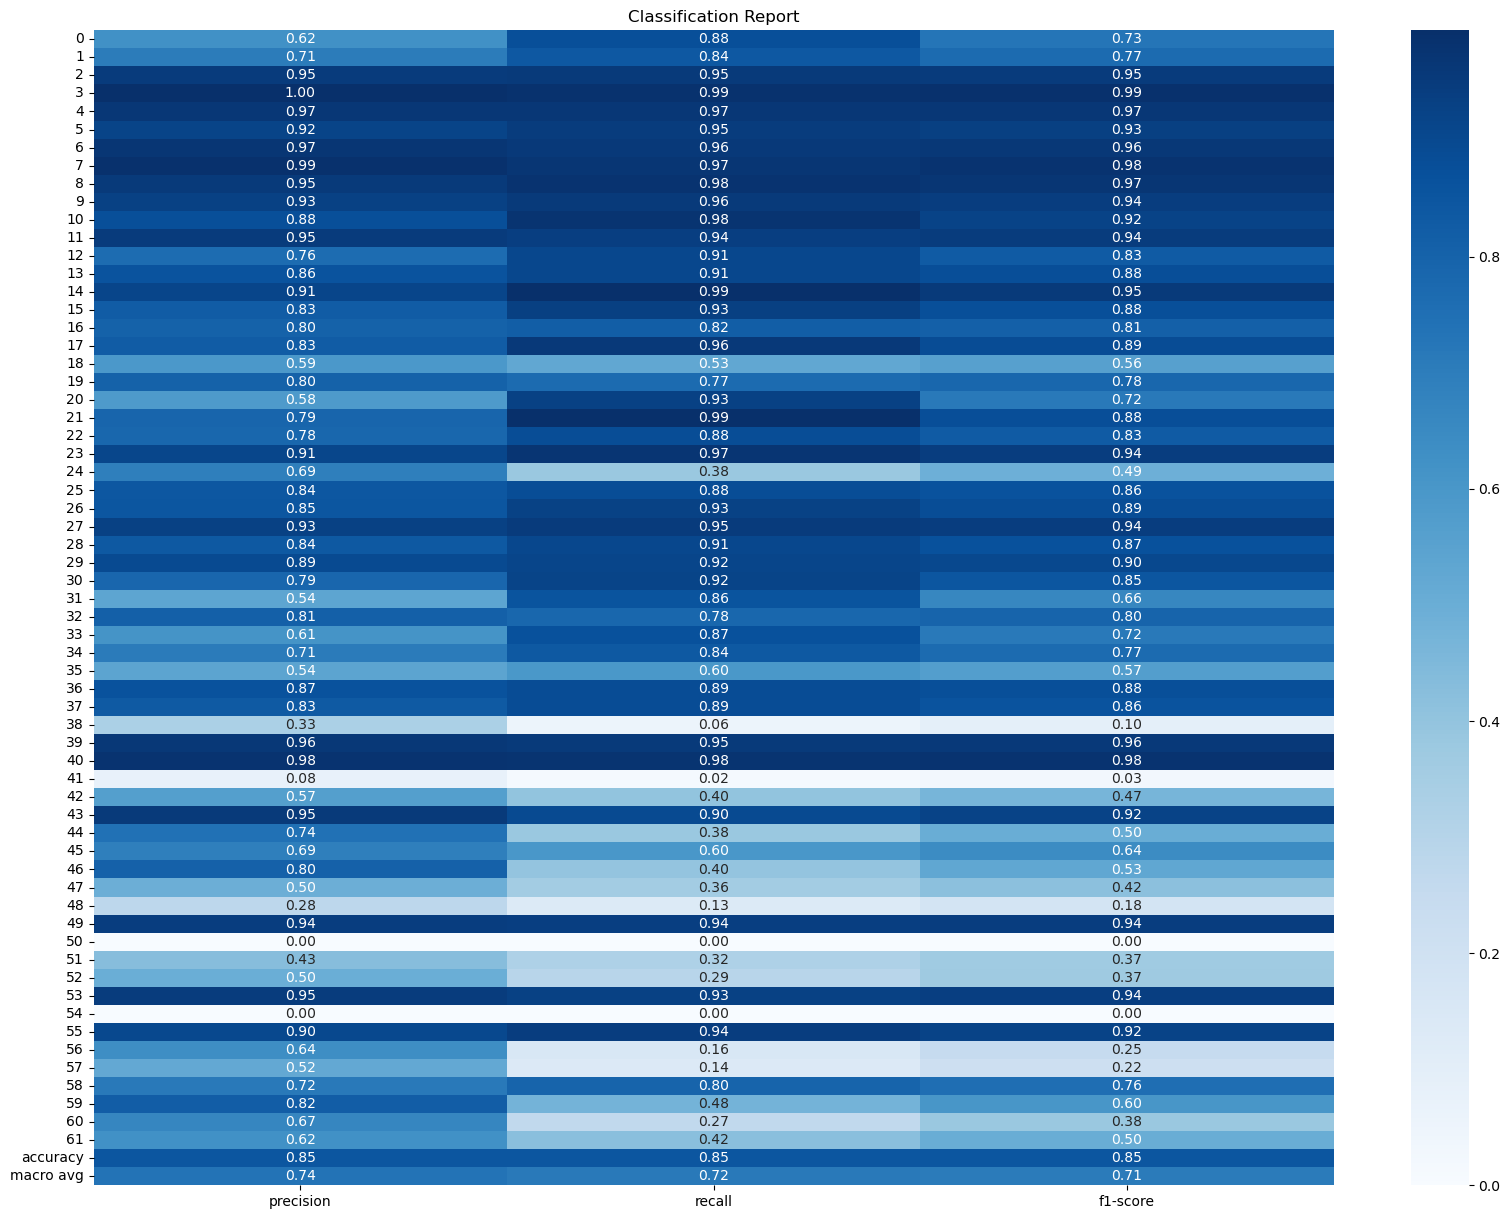

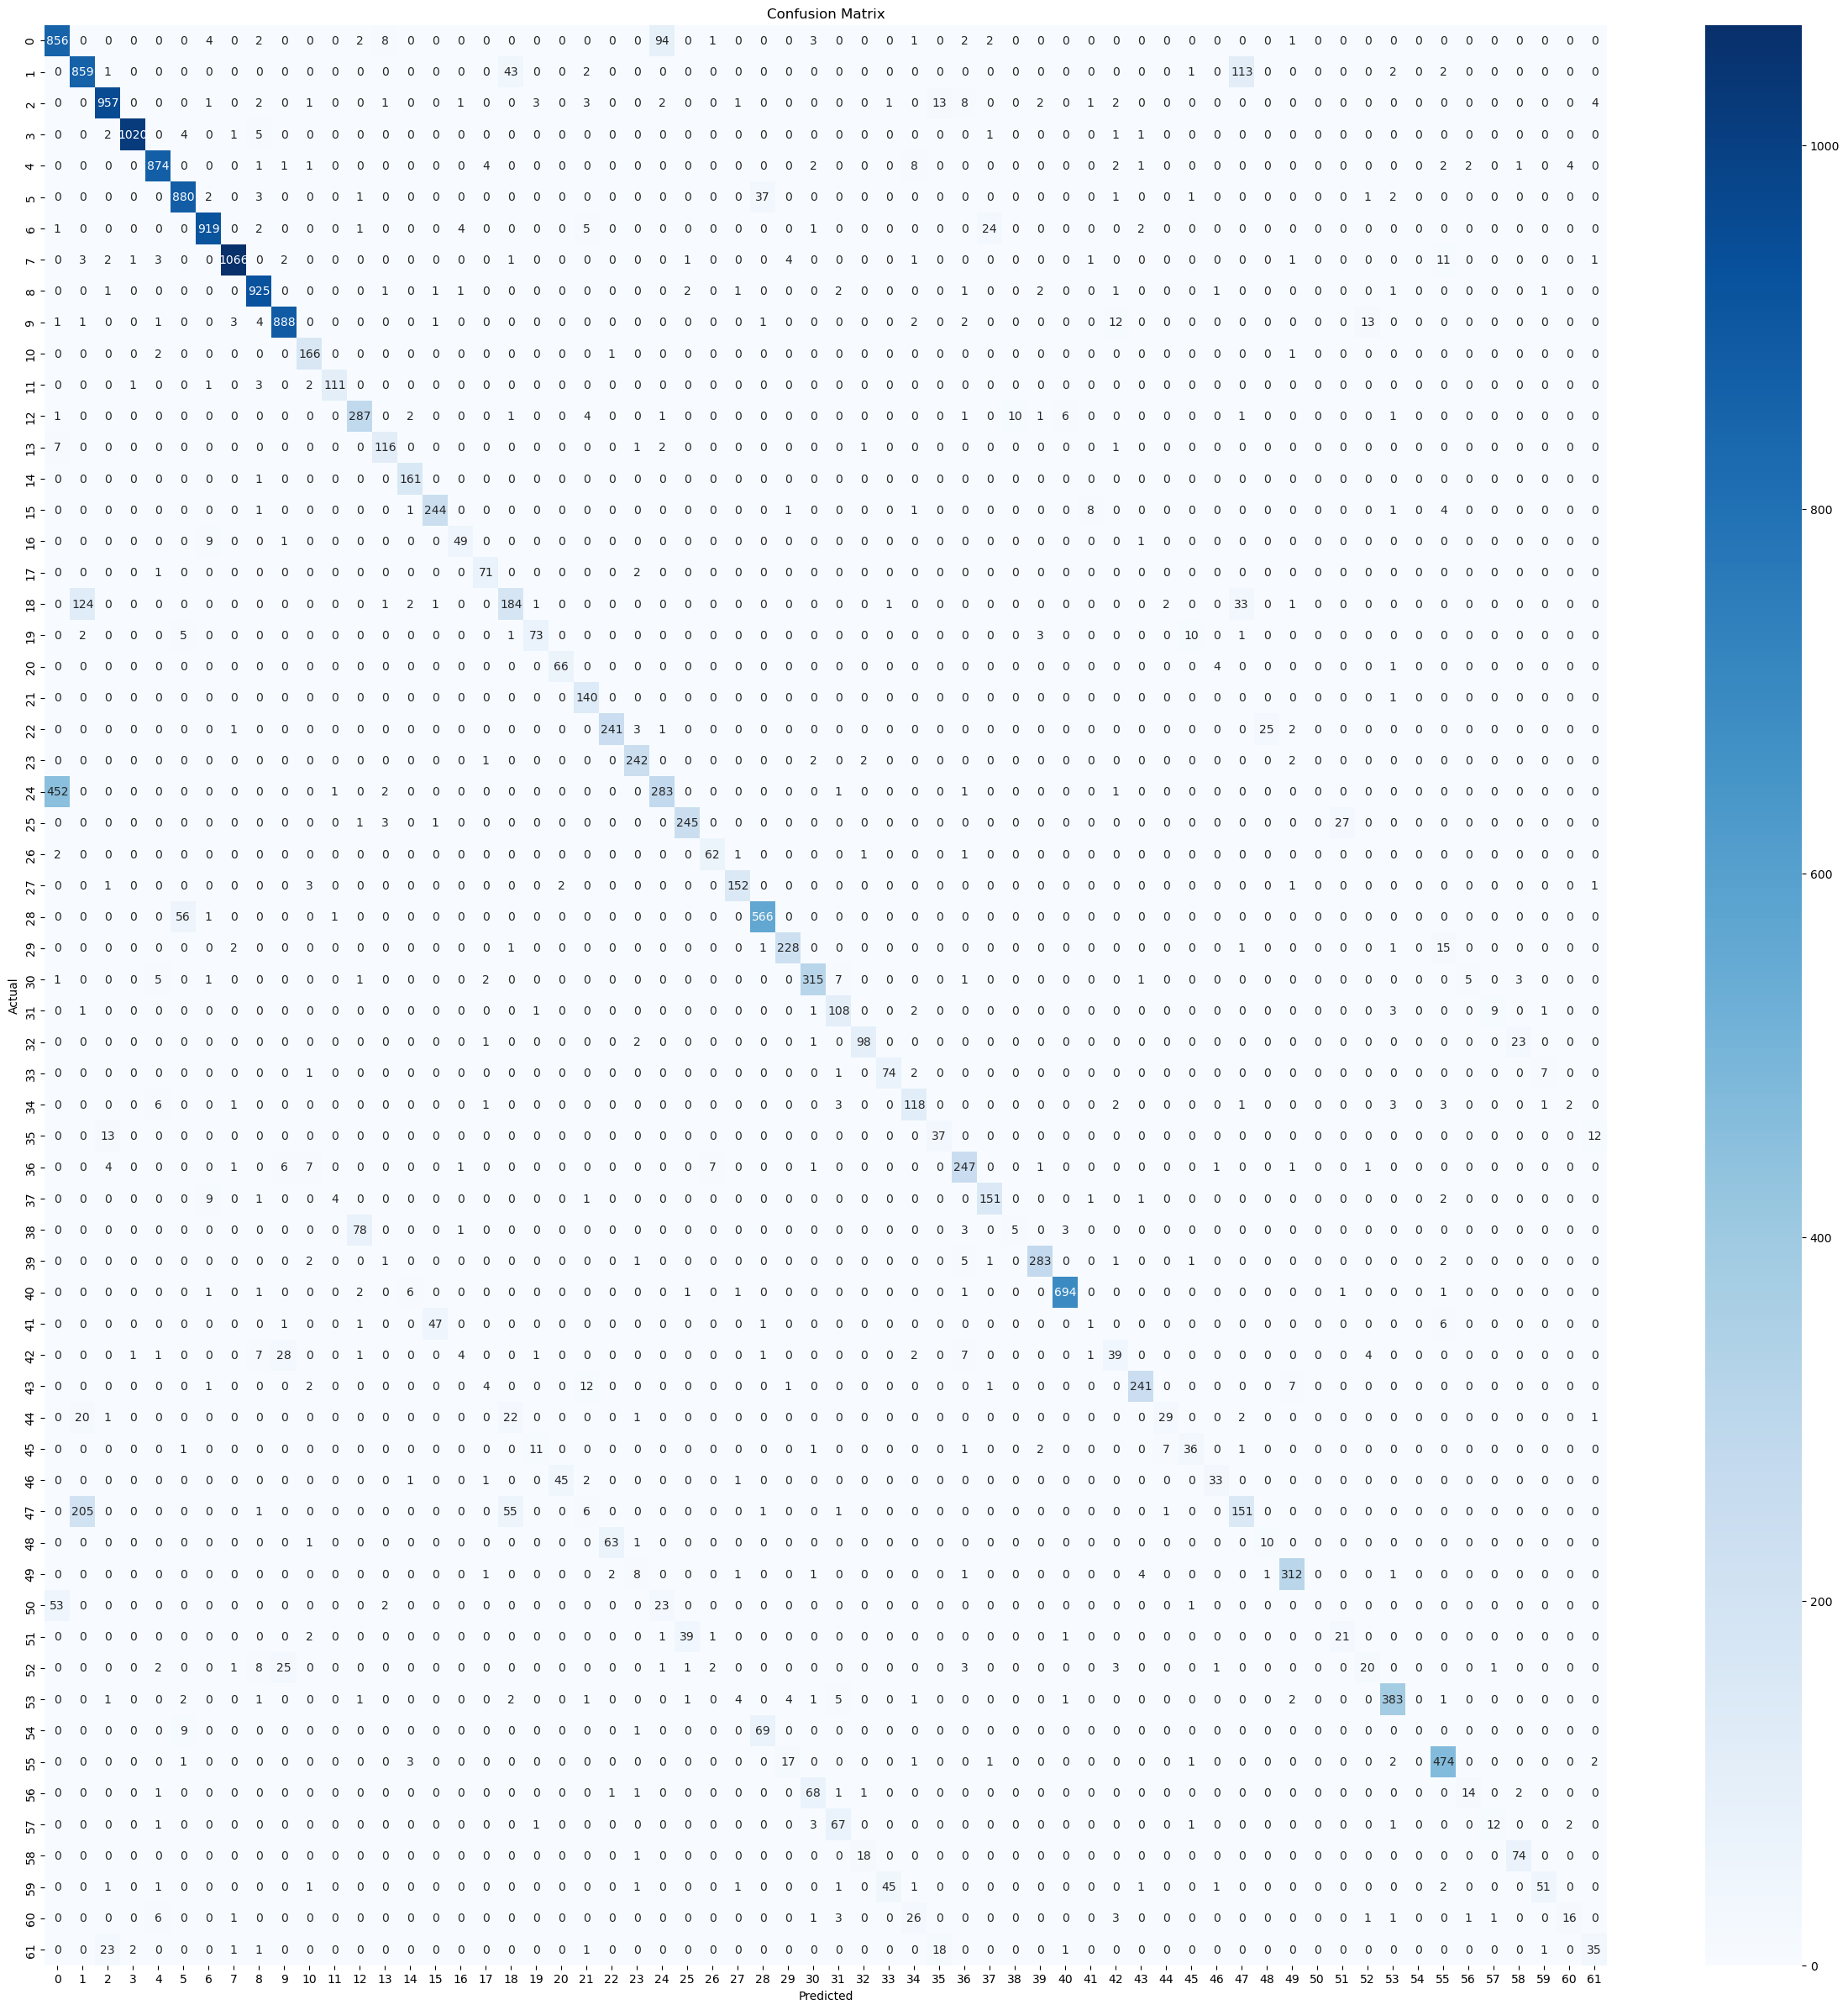

In [24]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# build EfficientNet model with the best parameters
best_EfficientNet = build_efficientnet_like(learning_rate = 0.001,
                                     survival_prob = 0.8, num_classes = 62)
# train the model
history3 = best_EfficientNet.fit(X_train_scaled, y_train,
                  validation_data = (X_validation_scaled, y_validation),
                              epochs = 20, batch_size = 128, verbose = 1)
# Evaluate model on the test set
predicted3 = best_EfficientNet.predict(X_test_scaled)
report3 = classification_report(y_test, predicted3.argmax(axis = 1),
                                      zero_division = 0,output_dict = True)
draw_table_classification_report(report3)
conf_matrix = confusion_matrix(y_test, predicted3.argmax(axis = 1))
plot_confusion_matrix(y_test, predicted3.argmax(axis = 1))


## 4.3 compare the three deep learning methods by radar chart
Using radar chart to compare the performance of three deep learning methods on the test dataset.

In [25]:
# get accuracy, precision, recall, f1_score, auc_roc
model_performance = {}
def evaluate_model(model, X_test_scaled, y_test, model_name):
    predicted = model.predict(X_test_scaled)
    actual = y_test
    report = classification_report(y_test, predicted.argmax(axis = 1), 
                                   zero_division = 0, output_dict = True)
    accuracy = accuracy_score(actual, predicted.argmax(axis = 1))
    precision = precision_score(actual, predicted.argmax(axis = 1), 
                              average = 'weighted', zero_division = 0)
    recall = recall_score(actual, predicted.argmax(axis = 1), 
                             average = 'weighted', zero_division = 0)
    f1 = f1_score(actual, predicted.argmax(axis = 1), 
                             average = 'weighted', zero_division = 0)
    y_test_bin = label_binarize(y_test, classes = [i for i in range(62)])
    auc_scores = []
    for i in range(y_test_bin.shape[1]):
        y_prob = predicted[:, i]
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob)
        auc_score = roc_auc_score(y_test_bin[:, i], y_prob)
        auc_scores.append(auc_score)
    auc_roc = sum(auc_scores) / len(auc_scores)
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc_roc}")
    print("\n")

# evaluate classification performance of each model
evaluate_model(best_CNN, X_test_scaled, y_test, "Simple CNN")
evaluate_model(best_ResNet, X_test_scaled, y_test, "ResNet-like")
evaluate_model(best_EfficientNet, X_test_scaled, y_test, "EfficientNet-like")


Model: Simple CNN
Accuracy: 0.8263
Precision: 0.8121272389909624
Recall: 0.8263
F1 Score: 0.8086167845564305
AUC-ROC: 0.9935069694017679


Model: ResNet-like
Accuracy: 0.85765
Precision: 0.8409751035919953
Recall: 0.85765
F1 Score: 0.841506165551694
AUC-ROC: 0.9955885595707262


Model: EfficientNet-like
Accuracy: 0.85065
Precision: 0.8389023985011945
Recall: 0.85065
F1 Score: 0.8374033479788704
AUC-ROC: 0.9941697489211302




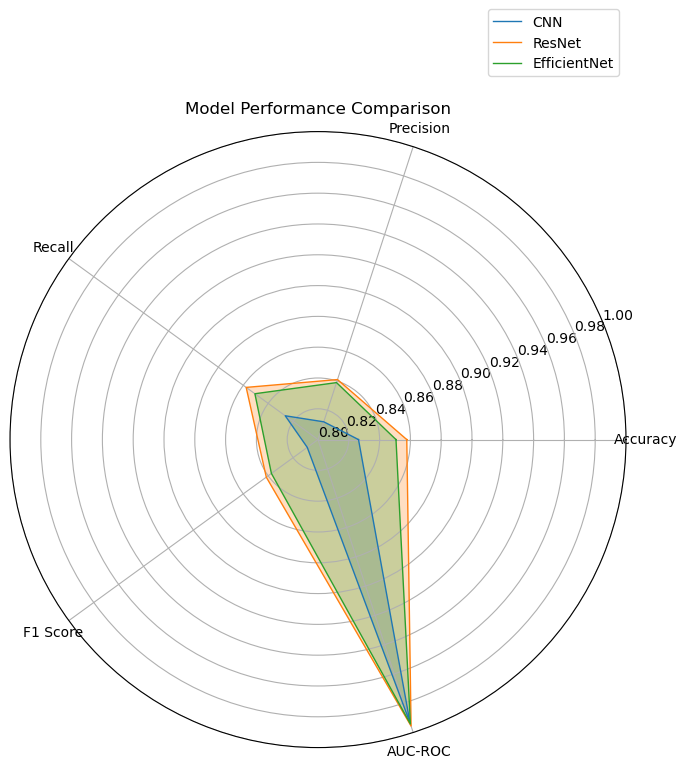

In [26]:
# draw the radar chat
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
scores = [
    [model_performance['Simple CNN'][label] for label in labels],
    [model_performance['ResNet-like'][label] for label in labels],
    [model_performance['EfficientNet-like'][label] for label in labels]
]
classifiers = ['CNN', 'ResNet', 'EfficientNet']
plot_radar_chart(labels, scores, classifiers, "Model Performance Comparison")

# 5. Final models
According to the comparision before, choose the ResNet-like architecture as the best model and get the best accuracy.

In [27]:
# TODO: Train and test the classifier which has the best performance
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)
# build ResNet model with the best parameters
best_ResNet = build_ResNet14(input_shape = (28, 28, 1), num_classes = 62,
                                        dropout = 0.3, learning_rate = 0.001)
# train the model
history1 = best_ResNet.fit(X_train_scaled, y_train,
                        validation_data = (X_validation_scaled, y_validation),
                          epochs = 20, batch_size = 256, verbose = 1)

Epoch 1/20
352/352 [==============================] - 7s 15ms/step - loss: 1.1682 - accuracy: 0.6737 - val_loss: 4.6763 - val_accuracy: 0.1530
Epoch 2/20
352/352 [==============================] - 5s 13ms/step - loss: 0.5795 - accuracy: 0.8037 - val_loss: 0.6053 - val_accuracy: 0.7988
Epoch 3/20
352/352 [==============================] - 5s 14ms/step - loss: 0.5028 - accuracy: 0.8248 - val_loss: 0.4577 - val_accuracy: 0.8409
Epoch 4/20
352/352 [==============================] - 5s 13ms/step - loss: 0.4649 - accuracy: 0.8345 - val_loss: 0.4548 - val_accuracy: 0.8389
Epoch 5/20
352/352 [==============================] - 5s 13ms/step - loss: 0.4440 - accuracy: 0.8416 - val_loss: 0.4296 - val_accuracy: 0.8470
Epoch 6/20
352/352 [==============================] - 5s 13ms/step - loss: 0.4282 - accuracy: 0.8445 - val_loss: 0.4199 - val_accuracy: 0.8487
Epoch 7/20
352/352 [==============================] - 5s 14ms/step - loss: 0.4172 - accuracy: 0.8482 - val_loss: 0.4149 - val_accuracy: 0.8489

In [28]:
y_predict_best = best_ResNet.predict(X_test_scaled)
# Convert probabilities to class labels
y_predict_best = np.argmax(y_predict_best, axis = 1)
accuracy_best = accuracy_score(y_predict_best, y_test)
print(f'Test Accuracy: {accuracy_best}')

Test Accuracy: 0.8586
